# Introduction

#_Brief Introduction to the project and its goals._#

# Setting up the Environment

### Importing Libraries

In [1]:
import os
import warnings

import requests
import urllib.request
from bs4 import BeautifulSoup

import time
from dateutil import relativedelta

import multiprocessing as mp

from IPython.display import HTML, display

import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns

# Data pre-processing
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, label_binarize

# Model Selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import plot_confusion_matrix

# Models
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

from sklearn.decomposition import PCA

### Notebook Display Settings


In [2]:
# Change the maximum number of rows displayed when viewing the pandas dataframe
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 50)

# Suppress all warnings
warnings.filterwarnings("ignore")

### Default Figure Settings

In [3]:
# Set plot properties
mpl.rcParams['axes.titlesize'] = 20
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['axes.titleweight']='bold'
mpl.rcParams['axes.labelweight']='normal'
mpl.rcParams['figure.figsize']=(8,6)

# Choose the font for the plots based on os (as some fonts are not available across different os)
if os.name=='nt':
    mpl.rcParams['font.family'] = "sans-serif"
    mpl.rcParams['font.sans-serif'] = "Arial"
elif os.name=='posix':  
    mpl.rcParams['font.family'] = "Mukti Narrow"

# Enables colour codes for seaborn plots
sns.set(color_codes=True)

### Declaring directories

In [4]:
SAVE_IMG = True

if(SAVE_IMG):
    img_dir = os.getcwd()
    img_dir = os.path.join(img_dir,os.pardir,'Report/images')

    if not(os.path.isdir(img_dir)):
            os.makedirs(img_dir)

csv_dir = os.getcwd()
csv_dir = os.path.join(csv_dir,'Data')

### Parallel Processing Configuration

In [5]:
# Get the number of cpu available for parallel processing
n_cpu=mp.cpu_count()

# Data Transformation & Exploration

## Read the Data

In [6]:
# Read the csv file 
data=pd.read_csv(os.path.join(csv_dir,'epl-training.csv'))

# Dropping the trailing columns
data.dropna(axis=1, how='all',inplace=True)
data.drop([column for column in data.columns if 'Unnamed' in column], axis = 1, inplace=True) 
print("Shape of the table (rows, columns): ", data.shape)

Shape of the table (rows, columns):  (4180, 22)


In [7]:
data.head()

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR
0,16/08/2008,Arsenal,West Brom,1,0,H,1,0,H,H Webb,24,5,14,4,11,8,7,5,0,0,0,0
1,16/08/2008,Bolton,Stoke,3,1,H,3,0,H,C Foy,14,8,8,2,13,12,4,3,1,2,0,0
2,16/08/2008,Everton,Blackburn,2,3,A,1,1,D,A Marriner,10,15,5,11,11,9,3,5,2,2,0,0
3,16/08/2008,Hull,Fulham,2,1,H,1,1,D,P Walton,11,12,6,6,10,9,5,6,3,0,0,0
4,16/08/2008,Middlesbrough,Tottenham,2,1,H,0,0,D,M Atkinson,14,8,10,5,11,12,7,9,1,2,0,0


### Update data

From initial observation it was seen that the data only includes match information fo up to Season 2018/19. Therefore, from the provided website the data for Season 2019/20 was added.

In [8]:
url = 'https://www.football-data.co.uk/mmz4281/1920/E0.csv'
response = requests.get(url)
# Check if url status code is 200
if response.status_code==200:
    print('Response OK!\nFile succesfully downloaded and data was updated.')
    # Download the csv file
    urllib.request.urlretrieve(url,'Data/E0.csv')
    # Pause the code for a sec
    time.sleep(1) 
    # Read the downloaded file
    data=data.append(pd.read_csv('Data/E0.csv',usecols=data.columns), 
                ignore_index=True) 
else:
    print('Response wasn\'t OK!\nFile could not be downloaded and data wasn not updated.')

Response OK!
File succesfully downloaded and data was updated.


In [9]:
data.shape

(4389, 22)

In [10]:
data.head()

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR
0,16/08/2008,Arsenal,West Brom,1,0,H,1,0,H,H Webb,24,5,14,4,11,8,7,5,0,0,0,0
1,16/08/2008,Bolton,Stoke,3,1,H,3,0,H,C Foy,14,8,8,2,13,12,4,3,1,2,0,0
2,16/08/2008,Everton,Blackburn,2,3,A,1,1,D,A Marriner,10,15,5,11,11,9,3,5,2,2,0,0
3,16/08/2008,Hull,Fulham,2,1,H,1,1,D,P Walton,11,12,6,6,10,9,5,6,3,0,0,0
4,16/08/2008,Middlesbrough,Tottenham,2,1,H,0,0,D,M Atkinson,14,8,10,5,11,12,7,9,1,2,0,0


## Exploratory Data Analysis

In [11]:
data.describe()

,FTHG,FTAG,HTHG,HTAG,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR
count,4389.00000,4389.000000,4389.000000,4389.000000,4389.000000,4389.000000,4389.000000,4389.000000,4389.000000,4389.000000,4389.000000,4389.000000,4389.000000,4389.000000,4389.000000,4389.000000
mean,1.55229,1.176806,0.683755,0.519025,14.118250,11.196628,6.076099,4.814992,10.663705,11.184324,6.049442,4.781727,1.478697,1.777626,0.060606,0.086352
std,1.30765,1.162777,0.839305,0.733627,5.493753,4.688795,3.459249,2.902698,3.439927,3.622321,3.139577,2.735153,1.202707,1.278367,0.246155,0.293609
min,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.00000,0.000000,0.000000,0.000000,10.000000,8.000000,4.000000,3.000000,8.000000,9.000000,4.000000,3.000000,1.000000,1.000000,0.000000,0.000000
50%,1.00000,1.000000,0.000000,0.000000,14.000000,11.000000,6.000000,4.000000,11.000000,11.000000,6.000000,4.000000,1.000000,2.000000,0.000000,0.000000
75%,2.00000,2.000000,1.000000,1.000000,17.000000,14.000000,8.000000,6.000000,13.000000,14.000000,8.000000,6.000000,2.000000,3.000000,0.000000,0.000000
max,9.00000,9.000000,5.000000,5.000000,43.000000,30.000000,24.000000,20.000000,28.000000,26.000000,20.000000,19.000000,7.000000,9.000000,2.000000,2.000000


### Function definitions

The function __get_pivot_column_vs_column_count__ returns a dataframe after pivoting a column against another column. The elements of dataframe represent counts of all the different combinations of __col1__ and __col2__ in the dataframe __df__.

In [12]:
def get_pivot_column_vs_column_count(df,col1,col2):
    return df.groupby([col1,col2]).size().reset_index().\
              rename(columns={0:'counts'}).\
              pivot(values='counts',index=col1,columns=col2)

The function __get_column_countplot__ plots a bar chart. The bar chart is representative of the column __col__ in the dataframe __df__. The function counts the occurances of each value taken by __col__ in combination with the different outcome of __FTR__ (i.e. H, D, A). 

In [13]:
def get_column_countplot(df,col,y='FTR',ax=None ):
    if ax is None:
        ax = plt.gca()
    df.groupby([col, y]).size().reset_index().\
       pivot(columns=y, index=col, values=0).\
       plot(kind='bar', stacked=True,ax=ax)
    ax.set_xlabel(col)
    ax.set_ylabel('Counts')
    ax.set_title('Count Plot: %s'%(col))

### Number of teams

#### Number of unique teams in the table:

In [14]:
data['HomeTeam'].nunique()

37

#### Checking if all the team in the column `HomeTeam` are in `AwayTeam`

In [15]:
np.array_equal(sorted(data['HomeTeam'].unique()),sorted(data['AwayTeam'].unique()))

True

#### List of all teams in the data:

In [16]:
print(sorted(data['HomeTeam'].unique()))

['Arsenal', 'Aston Villa', 'Birmingham', 'Blackburn', 'Blackpool', 'Bolton', 'Bournemouth', 'Brighton', 'Burnley', 'Cardiff', 'Chelsea', 'Crystal Palace', 'Everton', 'Fulham', 'Huddersfield', 'Hull', 'Leicester', 'Liverpool', 'Man City', 'Man United', 'Middlesbrough', 'Newcastle', 'Norwich', 'Portsmouth', 'QPR', 'Reading', 'Sheffield United', 'Southampton', 'Stoke', 'Sunderland', 'Swansea', 'Tottenham', 'Watford', 'West Brom', 'West Ham', 'Wigan', 'Wolves']


### Analysing the `Referee` column

#### The number of unique referees in dataset:

In [17]:
data['Referee'].nunique()

40

> This is 3  referee names more than expected.

In [18]:
data['Referee'].unique()

array(['H Webb', 'C Foy', 'A Marriner', 'P Walton', 'M Atkinson',
       'A Wiley', 'S Bennett', 'P Dowd', 'M Dean', 'M Riley', 'S Attwell',
       'M Halsey', 'R Styles', 'K Stroud', 'M Jones', 'S Tanner',
       'L Probert', 'L Mason', 'M Clattenburg', 'K Friend', 'St Bennett',
       'Mn Atkinson', 'A Taylor', 'M Oliver', 'N Swarbrick', 'J Moss',
       'R East', 'C Pawson', 'R Madley', 'P Tierney', 'G Scott',
       'S Hooper', 'C Kavanagh', 'l Mason', 'D Coote', 'A Madley',
       'O Langford', 'P Bankes', 'T Robinson', 'R Jones'], dtype=object)

From the list above it was noticed that the following referee names seem to have been repeated in different ways:
- `L Mason` and `l Mason`
- `S Bennett` and `St Bennett` 
- `M Atkinson` and `Mn Atkinson`

In [19]:
data['Referee']=data['Referee'].replace({'l Mason':'L Mason',
                                         'St Bennett':'S Bennett',
                                         'Mn Atkinson':'M Atkinson'})

In [20]:
data['Referee'].nunique()==data['HomeTeam'].nunique()

True

> It can be seen that the number of referees here is the same as the number of teams

### Analysing the Dates

The first and the last date (when arranged chronologically) observed in the table:

In [21]:
# Convert to datetime type
data['Date']=pd.to_datetime(data['Date'], format='%d/%m/%Y')

In [22]:
print("The earliest date in the table: ", data['Date'].min())
print("The latest date in the table: ", data['Date'].max())

The earliest date in the table:  2008-08-16 00:00:00
The latest date in the table:  2020-01-02 00:00:00


In [23]:
rd = relativedelta.relativedelta(data['Date'].max(),data['Date'].min())
print('%d years %d months %d days'%(rd.years,rd.months,rd.days))

11 years 4 months 17 days


In [24]:
sorted((data['Date'].dt.month).unique())

[1, 2, 3, 4, 5, 8, 9, 10, 11, 12]

It can be seen here that 6 and 7 are missing.

> This means that no matches happen in June and July.

Therefore, we can consider that: 

> Each Season starts from __August to May__ and so we can deduce that the data covers __11 Seasons__

### Number of Matches played by the teams

A count of the occurances of each combination of Home and Away team allocation.

In [25]:
get_pivot_column_vs_column_count(data,'HomeTeam','AwayTeam')

AwayTeam,Arsenal,Aston Villa,Birmingham,Blackburn,Blackpool,Bolton,Bournemouth,Brighton,Burnley,Cardiff,Chelsea,Crystal Palace,Everton,Fulham,Huddersfield,Hull,Leicester,Liverpool,Man City,Man United,Middlesbrough,Newcastle,Norwich,Portsmouth,QPR,Reading,Sheffield United,Southampton,Stoke,Sunderland,Swansea,Tottenham,Watford,West Brom,West Ham,Wigan,Wolves
HomeTeam,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Arsenal,NaN,9.0,2.0,4.0,1.0,4.0,5.0,3.0,6.0,2.0,12.0,7.0,11.0,7.0,2.0,5.0,5.0,11.0,12.0,12.0,2.0,9.0,4.0,2.0,3.0,1.0,NaN,8.0,10.0,9.0,7.0,12.0,4.0,9.0,10.0,5.0,5.0
Aston Villa,8.0,NaN,2.0,4.0,1.0,4.0,2.0,1.0,3.0,1.0,8.0,3.0,9.0,6.0,NaN,4.0,3.0,9.0,8.0,8.0,1.0,8.0,5.0,2.0,3.0,1.0,NaN,5.0,8.0,8.0,5.0,8.0,1.0,7.0,8.0,5.0,3.0
Birmingham,2.0,2.0,NaN,2.0,1.0,2.0,NaN,NaN,1.0,NaN,2.0,NaN,2.0,2.0,NaN,1.0,NaN,2.0,2.0,2.0,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,2.0,2.0,NaN,2.0,NaN,1.0,2.0,2.0,2.0
Blackburn,4.0,4.0,2.0,NaN,1.0,4.0,NaN,NaN,1.0,NaN,4.0,NaN,4.0,4.0,NaN,2.0,NaN,4.0,4.0,4.0,1.0,3.0,1.0,2.0,1.0,NaN,NaN,NaN,4.0,4.0,1.0,4.0,NaN,3.0,3.0,4.0,3.0
Blackpool,1.0,1.0,1.0,1.0,NaN,1.0,NaN,NaN,NaN,NaN,1.0,NaN,1.0,1.0,NaN,NaN,NaN,1.0,1.0,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,1.0,NaN,1.0,1.0,1.0,1.0
Bolton,4.0,4.0,2.0,4.0,1.0,NaN,NaN,NaN,1.0,NaN,4.0,NaN,4.0,4.0,NaN,2.0,NaN,4.0,4.0,4.0,1.0,3.0,1.0,2.0,1.0,NaN,NaN,NaN,4.0,4.0,1.0,4.0,NaN,3.0,3.0,4.0,3.0
Bournemouth,5.0,1.0,NaN,NaN,NaN,NaN,NaN,2.0,4.0,1.0,4.0,4.0,5.0,1.0,2.0,1.0,4.0,5.0,5.0,5.0,1.0,3.0,2.0,NaN,NaN,NaN,1.0,4.0,3.0,2.0,3.0,4.0,4.0,3.0,5.0,NaN,2.0
Brighton,2.0,NaN,NaN,NaN,NaN,NaN,3.0,NaN,3.0,1.0,3.0,2.0,3.0,1.0,2.0,NaN,3.0,2.0,2.0,2.0,NaN,2.0,1.0,NaN,NaN,NaN,1.0,3.0,1.0,NaN,1.0,3.0,2.0,1.0,3.0,NaN,2.0
Burnley,5.0,3.0,1.0,1.0,NaN,1.0,3.0,2.0,NaN,1.0,6.0,5.0,6.0,2.0,2.0,3.0,4.0,6.0,6.0,6.0,1.0,4.0,1.0,1.0,1.0,NaN,NaN,5.0,4.0,3.0,3.0,5.0,3.0,3.0,6.0,1.0,2.0


Checking how many matches each team played. As every match a home team plays at home comes in conjunction with one it plays away, it is sufficient to count the number of home matches. 

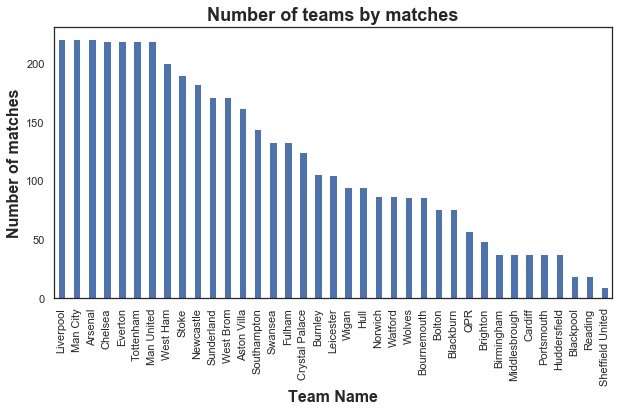

In [26]:
sns.set_style("white")
data.HomeTeam.value_counts().plot(kind='bar', figsize=(10,5))
plt.title('Number of teams by matches',fontsize=18, fontweight='bold')
plt.ylabel('Number of matches',fontsize=16, fontweight='bold')
plt.xlabel('Team Name',fontsize=16, fontweight='bold')
if(SAVE_IMG):
    fig1=plt.savefig(os.path.join(img_dir,'num_of_matches.png'))
plt.show()

### HTR vs. FTR

A count plot to show the relationship between Half Time Result (`HTR`) and Full Time Result (`FTR`). This was done basically to check for how many of the matches the `HTR` and `FTR` result.

In [27]:
get_pivot_column_vs_column_count(data,'HTR','FTR')

FTR,A,D,H
HTR,,,
A,747,208,108
D,457,673,677
H,75,206,1238


###  Histogram (Count Plots) of all Features

The columns of the unprocessed dataset will later be used to extract information about the individual teams. To investigate the characteristics of each of the individual columns, we first utilize a histogram plot of each of the columns. Prior to obtaining this plot, all the categorical columns (Home Team, Away Team, Referee and Full Time Result) are turned into numerical values using the __Label_Encoder__ function.

Bar Chart for each of the numerical features in the imported dataset. The bar chart will show a count of the occurances of each unique value taken by each feautre. In addition to this, the bar chart will show what proportion of each unique value that resulted in Home win (__H__), Draw (__D__) or Away win (__A__).

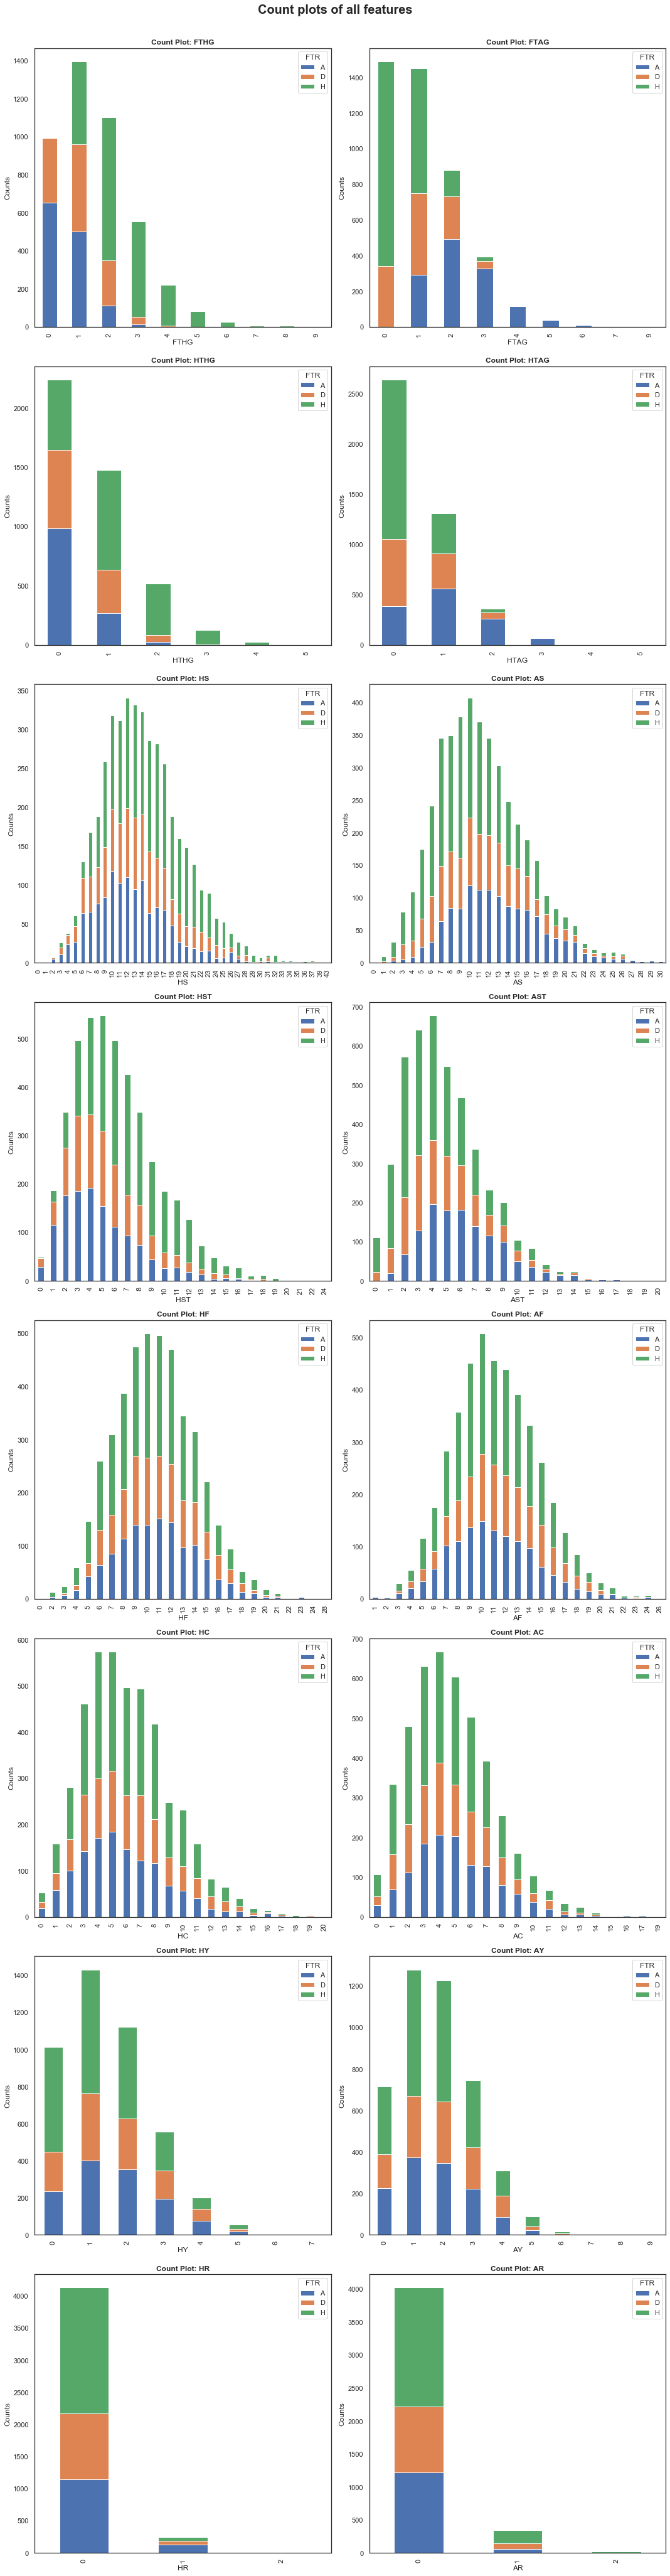

In [28]:
# Save the column names of numerical features as a list
num_col_list=[x for x in data.columns if x not in ['Date','HomeTeam','AwayTeam','Referee','FTR','HTR']]

# Reshaping array for easier formatting
num_col_list = np.reshape(num_col_list, (8, 2))

# Call the function get_column_countplot() to plot the count plot of the categorical columns as s ubplots in a figure
fig, axes = plt.subplots(8,2,figsize=(15,60))
sns.set_style("white")
for i in range(8):
    for j in range(2):
        get_column_countplot(data,num_col_list[i][j], ax=axes[i,j])
fig.tight_layout(rect=[0, 0.03, 1, 0.97])
fig.suptitle("Count plots of all features",fontweight='bold',fontsize=20)
if(SAVE_IMG):
    fig2=plt.savefig(os.path.join(img_dir,'count_plot_all.png'))
plt.show()

### Checking if the dataset is balanced

A bar chart showing the number of home wins, draws and away wins.

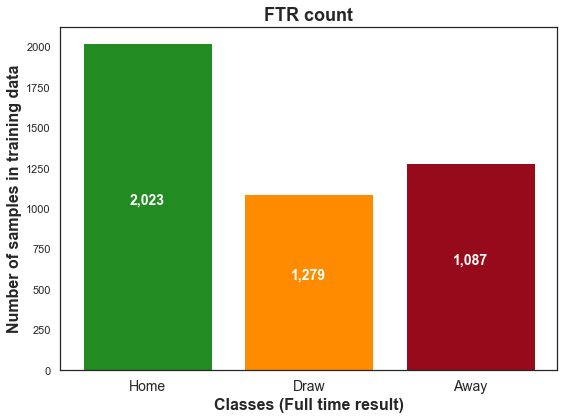

In [29]:
# Get the counts 
count_val=data['FTR'].value_counts()

# Visualise the count
X_ticks=['Home','Draw','Away']
bar_width=0.7
fig,ax=plt.subplots()
sns.set_style("white")
plt.bar(1,count_val[0],color='forestgreen')
plt.bar(2,count_val[2],color='darkorange')
plt.bar(3,count_val[1],color='#970a1b')
plt.text(1, count_val[0]/2, "{:,}".format(count_val[0]),color='w',
         ha='center', va= 'bottom',fontweight='bold',fontsize=14)
plt.text(2, count_val[2]/2, "{:,}".format(count_val[1]), color='w'
         ,ha='center', va= 'bottom',fontweight='bold',fontsize=14)
plt.text(3, count_val[1]/2, "{:,}".format(count_val[2]), color='w',
         ha='center', va= 'bottom', fontweight='bold', fontsize=14)
ax.set_title('FTR count', fontsize=18, fontweight='bold')
ax.set_xlabel('Classes (Full time result)', fontsize=16, fontweight='bold')
ax.set_ylabel('Number of samples in training data', fontsize=16, fontweight='bold')
ax.set_xticks([1,2,3])
ax.set_xticklabels(X_ticks,fontsize=14)
fig.tight_layout()
if(SAVE_IMG):
    fig3=plt.savefig(os.path.join(img_dir,'balance_check'))
plt.show()

#### Encoding the non-numerical columns

In [30]:
encoded_data = data.copy()

for column in ['HomeTeam','AwayTeam','Referee','FTR','HTR']:
    encoded_data[column] = LabelEncoder().fit_transform(encoded_data[column])

### Correlation Matrix of the Data

A visual plot of the correlation matrix between the all the raw columns of the provided dataset. This will help identify important columns as well as discard those that show no correlation. For this, the label encoded dataset will be utilized.

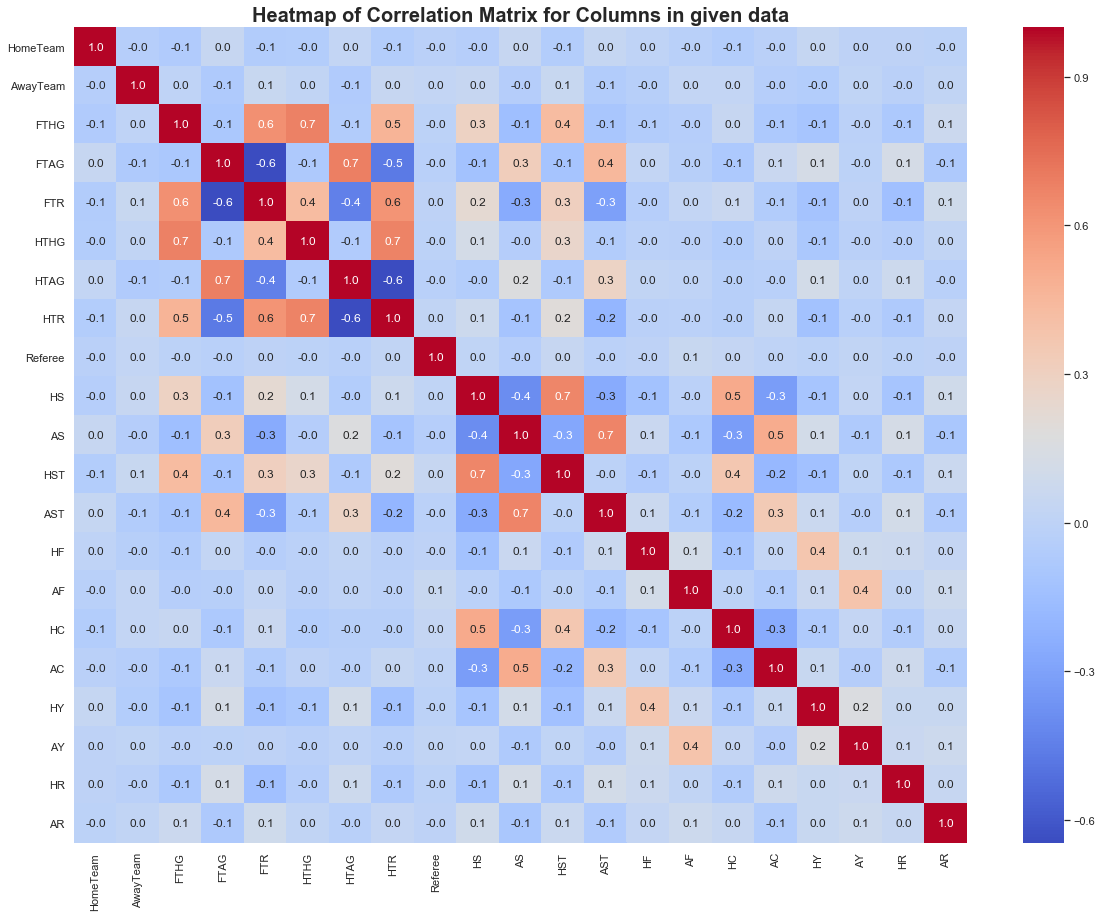

In [31]:
fig=plt.figure(figsize=(20,15))
ax = plt.subplot()
ax.set_title("Heatmap of Correlation Matrix for Columns in given data",fontsize=20,fontweight='bold')
sns.heatmap(encoded_data.corr(), annot = True, fmt='.1f', cmap= 'coolwarm', ax=ax)
if(SAVE_IMG):
    fig4=plt.savefig(os.path.join(img_dir,'raw_corr_heatmap.png'))
plt.show()

### Box-Plot of columns

A box-plot of the data in each column to provide insight into the spread of the data and identify outliers.

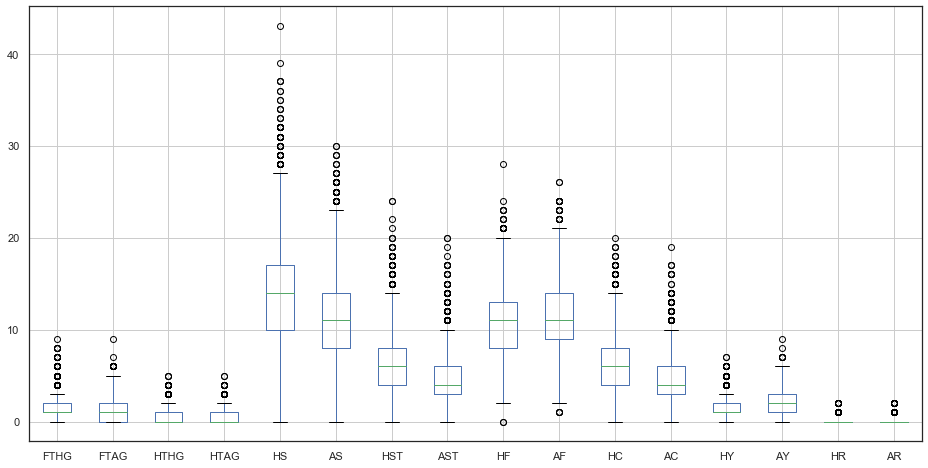

In [32]:
num_col_list=[x for x in data.columns if x not in ['Season','Date','HomeTeam','AwayTeam','Referee','FTR','HTR']]

numerical_data = data[num_col_list]

sns_plot = numerical_data.boxplot(figsize=(16,8));
if(SAVE_IMG):
    sns_plot.get_figure().savefig(os.path.join(img_dir,'raw_box_plot.png'))

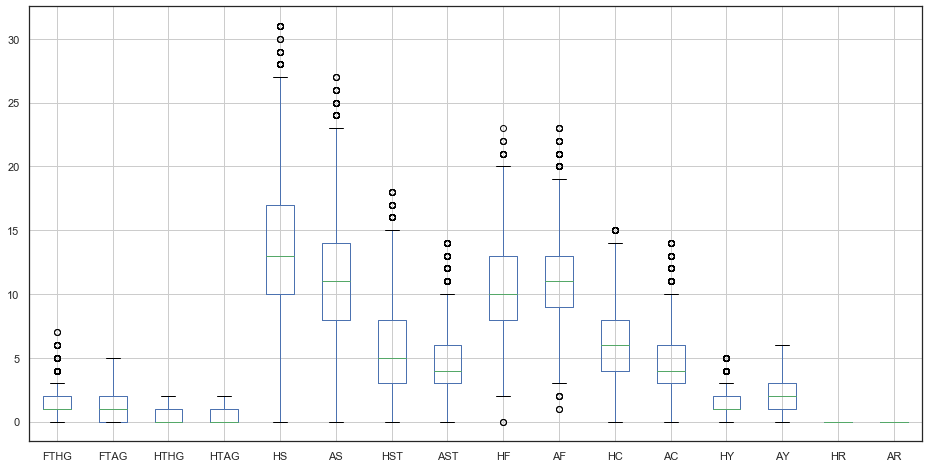

In [33]:
def trim_data(data, q1 = 0.25, q2 = 0.75):
    Q1 = data.quantile(q1); Q3 = data.quantile(q2);
    IQR = Q3 - Q1
    data_trimmed = data[~((data < (Q1 - 1.5 * IQR)) |(data > (Q3 + 1.5 * IQR))).any(axis=1)]
    return data_trimmed

q1 = 0.2
q2 = 0.8

data_trimmed = trim_data(numerical_data, q1, q2)
sns_plot = data_trimmed.boxplot(figsize=(16,8));
if(SAVE_IMG):
    sns_plot.get_figure().savefig(os.path.join(img_dir,'trimmed_box_plot.png'))

In [34]:
rows_org = int(numerical_data.shape[0])
rows_trimmed = int(data_trimmed.shape[0])
loss = rows_org - rows_trimmed

print('Loss of data:{} Percentage:{:.1f}%'.format(loss, 100 * loss/rows_org),
      '\nOld Data Numbers:', rows_org,
      '\nNew Data Numbers:', rows_trimmed
     )

Loss of data:890 Percentage:20.3% 
Old Data Numbers: 4389 
New Data Numbers: 3499


# Feature Extraction

### Average Goals, Points and Aggressiveness

Calculating average goals and scores for home teams and away teams. The scores are calculated by considering a win as 3 points, a draw as 1 point and a loss as 0 points. As the number of goals conceded by one team is the number of goals scored by the other team, the average number of goals conceded by the home team is equal to the number of goals scored by the away team (the same applies for goals conceded by the away team). These average values will be used to scale metrics later on in feature extraction to ensure that a value of 1 represents an average performance. This will ensure that the features are of similar scale. 

In [35]:
# Get total number of matches
num_matches = data.shape[0] 

# Sum home goals column, divide by total matches
average_home_goals = data.FTHG.sum()/num_matches

# Sum away goals column, divide by total matches
average_away_goals = data.FTAG.sum() /num_matches

# Average conceded goals = Average of goals for opposite team
avg_home_conceded = average_away_goals 
avg_away_conceded = avg_home_conceded

# Calculating points for each team
average_home_points = (3*count_val['H'] + count_val['D'])/num_matches
average_away_points = (3*count_val['A'] + count_val['D'])/num_matches

# Calculating other average  home and away
average_home_yellow = data.HY.sum()/num_matches
average_away_yellow = data.AY.sum()/num_matches
average_home_red = data.HR.sum()/num_matches
average_away_red = data.AR.sum()/num_matches
average_home_fouls = data.HF.sum()/num_matches
average_away_fouls = data.AF.sum()/num_matches

print('Average Home Goals:', average_home_goals)
print('Average Away Goals:', average_away_goals)
print('Average Home Points:',average_home_points)
print('Average Away Points:', average_away_points)
# print('Average Home Yellow Cards:', average_home_yellow)
# print('Average Away Yellow Cards:', average_away_yellow)
# print('Average Home Red Cards:',average_home_red)
# print('Average Away Red Cards:', average_away_red)
print('Average Home Fouls:',average_home_fouls)
print('Average Away Fouls:', average_away_fouls)

Average Home Goals: 1.5522898154477103
Average Away Goals: 1.176805650489861
Average Home Points: 1.6304397357028937
Average Away Points: 1.1218956482114377
Average Home Fouls: 10.663704716336296
Average Away Fouls: 11.184324447482343


### Calculation of Season

In [36]:
min_year = data['Date'].min().year

In [37]:
def applying_season(row):
    
    match_date = pd.to_datetime(row['Date'],format='%d/%m/%Y')
    match_month = match_date.month
    match_year = match_date.year
    
    years_since = match_year - min_year
    if match_month < 6:
        return years_since
    else:
        return (years_since + 1)

In [38]:
data['Season'] = data.apply(applying_season,axis=1)

In [39]:
data.tail()

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR,Season
4384,2020-01-01,Man City,Everton,2,1,H,0,0,D,A Marriner,16,7,7,2,11,11,3,6,0,4,0,0,12
4385,2020-01-01,Norwich,Crystal Palace,1,1,D,1,0,H,J Moss,15,12,4,3,12,9,2,5,5,0,0,0,12
4386,2020-01-01,West Ham,Bournemouth,4,0,H,3,0,H,G Scott,14,3,7,2,3,12,9,2,1,2,0,0,12
4387,2020-01-01,Arsenal,Man United,2,0,H,2,0,H,C Kavanagh,10,10,4,4,11,15,1,4,2,0,0,0,12
4388,2020-01-02,Liverpool,Sheffield United,2,0,H,1,0,H,P Tierney,19,3,7,2,5,8,8,4,0,0,0,0,12


### Team Statistics

Features in the raw data may be used to compute metrics that quantify different qualities of each team when they are playing at home and away. These quantities will be the same for all the home/away matches they play (i.e. a team will have the same Home Attacking Strength (HAS) for all games that it plays on home turf).

In [40]:
team_stats= pd.DataFrame(columns=('Team','HGS','AGS','HAS','AAS','HGC','AGC','HDS','ADS','HS','HST','AS','AST','HCON','ACON','HY','AY','HR','AR','HF','AF','HAGG','AAGG'))

In [41]:
# Group data by the teams
res_home = data.groupby('HomeTeam')
res_away = data.groupby('AwayTeam')

In [42]:
# Add the list of team names
team_stats.Team = pd.Series(data['HomeTeam'].unique())

In [43]:
# Home goal scored (HGS)
team_stats.HGS = res_home.FTHG.sum().values 
# Home goal conceded (HGC)
team_stats.HGC = res_home.FTAG.sum().values

In [44]:
# Away goal scored (AGS)
team_stats.AGS = res_away.FTAG.sum().values 
# Away goal conceded (AGC)
team_stats.AGC = res_away.FTHG.sum().values 

In [45]:
# Calculate number of games played
total_home_games_played = res_home.FTHG.count()
total_away_games_played = res_away.FTAG.count()

In [46]:
# Home Attacking Strength
team_stats.HAS = (np.divide(team_stats.HGS,total_home_games_played.values)) / average_home_goals
# Away Attacking Strength
team_stats.AAS = (np.divide(team_stats.AGS,total_away_games_played.values)) / average_away_goals

In [47]:
# Home Defensive Strength
team_stats.HDS = (np.divide(team_stats.HGC,total_home_games_played.values)) / avg_home_conceded
# Away Defensive Strength
team_stats.ADS = (np.divide(team_stats.AGC,total_away_games_played.values)) / avg_away_conceded

In [48]:
# Obtaining for each team: Average number of goals scored and conceded when at home and at away.
team_stats.GSA = (np.divide(team_stats.AGS,total_away_games_played.values))
team_stats.GSH = (np.divide(team_stats.HGS,total_home_games_played.values))

team_stats.GCA = (np.divide(team_stats.AGC,total_away_games_played.values))
team_stats.GCH = (np.divide(team_stats.HGC,total_home_games_played.values))

In [49]:
# Shots taken at home and away
team_stats.HS = res_home.HS.sum().values 
team_stats.AS = res_away.AS.sum().values

# Shots taken on target at home and away
team_stats.HST = res_home.HST.sum().values 
team_stats.AST = res_away.AST.sum().values

# Shot conversion rate (accuracy) at home and away
team_stats.HCON = (np.divide(team_stats.HST,team_stats.HS)) 
team_stats.ACON = (np.divide(team_stats.AST,team_stats.AS)) 

In [50]:
# Average number of yellow/red cards home and away
team_stats.HY = (np.divide(res_home.HY.sum().values,total_home_games_played.values))
team_stats.AY = (np.divide(res_home.AY.sum().values,total_home_games_played.values))

team_stats.HR = (np.divide(res_home.HR.sum().values,total_home_games_played.values))
team_stats.AR = (np.divide(res_home.AR.sum().values,total_home_games_played.values))

In [51]:
# Total number of fouls at home and away
team_stats.HF = res_home.HF.sum().values 
team_stats.AF = res_away.AF.sum().values

# A measure of aggressiveness for each team
team_stats.HAGG = (np.divide(team_stats.HF,total_home_games_played.values)) / average_home_fouls
team_stats.AAGG = (np.divide(team_stats.AF,total_away_games_played.values)) / average_away_fouls

In [52]:
team_stats.head()

,Team,HGS,AGS,HAS,AAS,HGC,AGC,HDS,ADS,HS,HST,AS,AST,HCON,ACON,HY,AY,HR,AR,HF,AF,HAGG,AAGG
0,Arsenal,458,367,1.341127,1.424024,191,305,0.737744,1.183453,3595,1693,2827,1308,0.470932,0.462681,1.513636,1.959091,0.068182,0.100000,2268,2225,0.966746,0.908398
1,Bolton,192,170,0.763508,0.886251,212,287,1.112029,1.496200,1950,858,1603,743,0.440000,0.463506,1.524691,1.790123,0.067901,0.104938,1765,1941,1.021696,1.064702
2,Everton,38,37,0.644210,0.827396,35,70,0.782672,1.565344,379,186,321,189,0.490765,0.588785,1.578947,1.736842,0.078947,0.078947,390,417,0.962438,0.981166
3,Hull,98,77,0.830691,0.860939,90,162,1.006292,1.811326,949,501,689,385,0.527924,0.558781,1.592105,1.565789,0.052632,0.065789,957,950,1.180838,1.117636
4,Middlesbrough,30,25,1.017173,1.118103,37,41,1.654792,1.833688,253,134,193,101,0.529644,0.523316,1.157895,1.368421,0.000000,0.157895,216,187,1.066086,0.879991


Not all the features in the table above will be used in the final input features of the classifier. Some of these statistics are intermediate values which aided in the calculation of other statistics. For example the __HGS__ column was used to compute the __HAS__ column. 

### Team Statistics by Season

Each of the aforementioned statstics are now computed per season for each team. The season specific metrics are appeneded to the previously computed team statistcs table.

In [53]:
num_of_seasons  = data['Season'].max()

for season in range(1,num_of_seasons+1):
    temp_team_stats = pd.DataFrame(columns=('Team',('HGS%d'%(season)),('AGS%d'%(season)),\
                                            ('HAS%d'%(season)),('AAS%d'%(season)),\
                                            ('HGC%d'%(season)),('AGC%d'%(season)),\
                                            ('HDS%d'%(season)),('ADS%d'%(season)),\
                                            ('HS%d'%(season)),('AS%d'%(season)),\
                                            ('HST%d'%(season)),('AST%d'%(season)),\
                                            ('HCON%d'%(season)),('ACON%d'%(season)),\
                                            ('HF%d'%(season)),('AF%d'%(season)),\
                                            ('HAGG%d'%(season)),('AAGG%d'%(season))))
    
    # Obtain all matches played in current season
    season_matches = data[(data['Season']==season)]
    
    # Obtain list of unique teams
    temp_team_stats['Team'] = pd.Series(season_matches['HomeTeam'].unique())
    
    # Sort matches by home team and away team
    home_sorted = season_matches.groupby('HomeTeam')
    away_sorted = season_matches.groupby('AwayTeam')
    
    temp_team_stats['HGS%d'%(season)] = home_sorted.FTHG.sum().values
    temp_team_stats['HGC%d'%(season)] = home_sorted.FTAG.sum().values
    
    temp_team_stats['AGS%d'%(season)] = away_sorted.FTAG.sum().values
    temp_team_stats['AGC%d'%(season)] = away_sorted.FTHG.sum().values
    
    total_home_games_played = home_sorted.FTHG.count()
    total_away_games_played = away_sorted.FTAG.count()
    
    temp_team_stats['HAS%d'%(season)] = (np.divide(temp_team_stats['HGS%d'%(season)],total_home_games_played.values)) / average_home_goals 
    temp_team_stats['AAS%d'%(season)] = (np.divide(temp_team_stats['AGS%d'%(season)],total_away_games_played.values)) / average_away_goals
    
    temp_team_stats['HDS%d'%(season)] = (np.divide(temp_team_stats['HGC%d'%(season)],total_home_games_played.values)) / avg_home_conceded
    temp_team_stats['ADS%d'%(season)] = (np.divide(temp_team_stats['AGC%d'%(season)],total_away_games_played.values)) / avg_away_conceded
    
    temp_team_stats['HS%d'%(season)] = home_sorted.HS.sum().values 
    temp_team_stats['AS%d'%(season)] = away_sorted.HS.sum().values 
    
    temp_team_stats['HST%d'%(season)] = home_sorted.HST.sum().values 
    temp_team_stats['AST%d'%(season)] = away_sorted.HST.sum().values 
    
    temp_team_stats['HCON%d'%(season)] = (np.divide(temp_team_stats['HST%d'%(season)],temp_team_stats['HS%d'%(season)])) 
    temp_team_stats['ACON%d'%(season)] = (np.divide(temp_team_stats['AST%d'%(season)],temp_team_stats['AS%d'%(season)])) 
    
    temp_team_stats['HF%d'%(season)] = home_sorted.HF.sum().values 
    temp_team_stats['AF%d'%(season)] = away_sorted.AF.sum().values
    
    temp_team_stats['HAGG%d'%(season)] = (np.divide(temp_team_stats['HF%d'%(season)],total_home_games_played.values)) / average_home_fouls
    temp_team_stats['AAGG%d'%(season)] = (np.divide(temp_team_stats['AF%d'%(season)],total_away_games_played.values)) / average_away_fouls
    
    team_stats = team_stats.merge(temp_team_stats, on='Team', how='outer')

### Substituting for null values

Not all the teams compete in all seasons therefore some seasons will have NaN values for specific teams. This will cause issues late when training the model. To overcome these issues, the NaN datapoints are treated as missing data and substituted with the mean value of the metric.

In [54]:
def get_season_match_stats(match,season_offset=0):
    current_season = match['Season'] + season_offset
    
    if (current_season > 1) and (not np.isnan(team_stats[team_stats['Team']==match['HomeTeam']]['HAS%d'%(current_season)].values)):
        HAS = team_stats[team_stats['Team']==match['HomeTeam']]['HAS%d'%(current_season)].values[0]
        HDS = team_stats[team_stats['Team']==match['HomeTeam']]['HDS%d'%(current_season)].values[0]
        HCON = team_stats[team_stats['Team']==match['HomeTeam']]['HCON%d'%(current_season)].values[0]
        HAGG = team_stats[team_stats['Team']==match['HomeTeam']]['HAGG%d'%(current_season)].values[0]
    else:
        HAS = team_stats[team_stats['Team']==match['HomeTeam']]['HAS'].values[0]
        HDS = team_stats[team_stats['Team']==match['HomeTeam']]['HDS'].values[0]
        HCON = team_stats[team_stats['Team']==match['HomeTeam']]['HCON'].values[0]
        HAGG = team_stats[team_stats['Team']==match['HomeTeam']]['HAGG'].values[0]
    
    if (current_season > 1) and (not np.isnan(team_stats[team_stats['Team']==match['AwayTeam']]['AAS%d'%(current_season)].values)):
        AAS = team_stats[team_stats['Team']==match['AwayTeam']]['AAS%d'%(current_season)].values[0]
        ADS = team_stats[team_stats['Team']==match['AwayTeam']]['ADS%d'%(current_season)].values[0]
        ACON = team_stats[team_stats['Team']==match['AwayTeam']]['ACON%d'%(current_season)].values[0]
        AAGG = team_stats[team_stats['Team']==match['AwayTeam']]['AAGG%d'%(current_season)].values[0]
    else:
        AAS = team_stats[team_stats['Team']==match['AwayTeam']]['AAS'].values[0]
        ADS = team_stats[team_stats['Team']==match['AwayTeam']]['ADS'].values[0]
        ACON = team_stats[team_stats['Team']==match['AwayTeam']]['ACON'].values[0]
        AAGG = team_stats[team_stats['Team']==match['AwayTeam']]['AAGG'].values[0]
        
    return HAS, HDS, HCON, HAGG, AAS, ADS, ACON, AAGG

### Calculation of Form

Form is a calculation of a team's recent performance. Additionally these statistics vary with different allocations. (i.e. a team may have different __FFPTSH__ for different matches played at home). The function __get_features_match__ takes a match info and number of matches as inputs. The function then finds the number of past matches where the two teams played each other. If __n__ or more such matches exist, then the function computes 3 quantities: __FFPTSH__: Average points of home team in the past n matches against the away team, __FFHG__: Average goals of away team against home team in past n matches and __FFAG__: Average goals of home team against away team in the past n matches. If no matches are found then, the average quantities for these statistics are used. 

In [55]:
def get_form_match(match, is_test=False,n=5):
    home_team = match['HomeTeam']
    away_team = match['AwayTeam']
    # Constructing a table when all the matches between the two teams are shown.
    res = data[((data['HomeTeam']==home_team) & (data['AwayTeam']==away_team)) | ((data['AwayTeam']==home_team) & (data['HomeTeam']==away_team))]
    if not is_test:
        name = match.name
        idx = res.index.get_loc(name)
    else:
        idx= len(res) - 1
    
    pts_home =0
    pts_away =0
    goals_home =0
    goals_away =0
    
    if idx == 0:
        # If there is 0 matches between the teams
        pts_home_avg = average_home_points
        pts_away_avg = average_away_points
        goals_home_avg = average_home_goals
        goals_away_avg = average_away_goals
        
    else:
        if idx >= n: 
            #If there is at least n matches between the teams
            matches = res.iloc[idx-n:idx]
        else:
            matches = res.iloc[0:idx]
            
        avg_den=len(matches)
        
        for comb in [['H','A'],['A','H']]:
            c1=comb[0]
            c2=comb[1]
            if comb==['H','A']:
                matches_subset = matches[(matches['HomeTeam']==home_team) & (data['AwayTeam']==away_team)]
            elif comb==['A','H']:
                matches_subset = matches[(matches['HomeTeam']==away_team) & (data['AwayTeam']==home_team)]
                
            pts_home+=(len(matches_subset[matches_subset['FTR']==c1])*3)+len(matches_subset[matches_subset['FTR']=='D'])
            pts_away+=(len(matches_subset[matches_subset['FTR']==c2])*3)+len(matches_subset[matches_subset['FTR']=='D'])
            goals_home+=matches_subset['FT%cG'%(c1)].sum()
            goals_away+=matches_subset['FT%cG'%(c2)].sum()
            
        pts_home_avg = pts_home/avg_den
        pts_away_avg = pts_away/avg_den
        goals_home_avg = goals_home/avg_den
        goals_away_avg = goals_away/avg_den
        
    return pts_home_avg, pts_away_avg, goals_home_avg, goals_away_avg

Another measure of form is the winning streak of the team. The fucntion __get_features_streak_home__ takes match info and the number of matches to consider as the inputs. It computes three quantities: __PSH__ the point streak of the home team, __SSH__ the average goals over the past __n__ games for the home team and __CSH__ the average goals conceded over the past __n__ matches for the home team. A similar function called __get_features_streak_away__ does the same for the away team. 

In [56]:
def get_streak_team(match,team_type, is_test=False,n=15):
    team = match[team_type]
    team_data = data[((data['HomeTeam']==team) | (data['AwayTeam']==team))]
    
    if not is_test:
        name = match.name
        idx = team_data.index.get_loc(name)
    else:
        idx= len(team_data) - 1
    
    pts=0
    goals_scored=0
    goals_conceded=0
    
    if idx == 0:
        pts_avg = average_home_points
        goals_scored_avg = average_home_goals
        goals_conceded_avg = average_away_goals
    else:
        if idx-n < 0:
            newidx = 0
        else:
            newidx = idx - n
            
        matches_team = team_data.iloc[newidx:idx]
        m = len(matches_team)
        
        for c in ['H','A']:
            if c=='H':
                matches_subset=matches_team[matches_team['HomeTeam']==team]
                other_c='A'
            elif c=='A':
                matches_subset=matches_team[matches_team['AwayTeam']==team]
                other_c='H'
            pts+=(len(matches_subset[matches_subset['FTR']==c])*3)+len(matches_subset[matches_subset['FTR']=='D'])
            goals_scored+=matches_subset['FT%cG'%(c)].sum()
            goals_conceded+=matches_subset['FT%cG'%(other_c)].sum()
            
        pts_avg = pts/m
        goals_scored_avg = goals_scored/m
        goals_conceded_avg = goals_conceded/m
    return pts_avg, goals_scored_avg, goals_conceded_avg

### Finding Manager name

Request to get Premier League managers information from the relevant Wikipedia page and parse the information extracted in HTML format.

In [57]:
url = 'https://en.wikipedia.org/wiki/List_of_Premier_League_managers'
response = requests.get(url)
output = BeautifulSoup(response.text,"html.parser")

The table containing a list of all Team Managers that were/are in the Premier League is scraped from the above website.
The table  contains information regarding their Name, the club they worked for, start and end dates,
duration of their contract, and the years they had been in the league.

In [58]:
table = output.findAll('table',{"class":"wikitable"})[1]
tr = table.findAll(['tr'])

We convert the table from HTML format into pandas dataframe format.

In [59]:
rows = []
for cell in tr:
    th = cell.find_all('th')
    th_data = [col.text.strip('\n') for col in th]
    td = cell.find_all('td')
    row = []
    for i in td:
        if i.findAll(['img']):
            row.append(i.findAll(['img'])[0].get('alt',' '))
        else:
            row.append(i.text.replace('\n',''))
    rows.append(th_data+row)
column_headers = rows[0]
rows = rows[1:]

In [60]:
manager_df = pd.DataFrame(rows,columns=column_headers).drop(columns='Ref.')
manager_df.head(20)

,Name,Nat.,Club,From,Until,Duration(days),Years inLeague
0,George Graham,Scotland,Arsenal,14 May 1986,21 February 1995,3205,1992–1995
1,Stewart Houston,Scotland,Arsenal,22 February 1995,8 June 1995,106,1995
2,Bruce Rioch,Scotland,Arsenal,8 June 1995,12 August 1996,431,1995–1996
3,Stewart Houston,Scotland,Arsenal,12 August 1996,13 September 1996,32,1996
4,Pat Rice,Northern Ireland,Arsenal,13 September 1996,30 September 1996,17,1996
5,Arsène Wenger,France,Arsenal,1 October 1996,13 May 2018,7894,1996–2018
6,Unai Emery,Spain,Arsenal,23 May 2018,29 November 2019,555,2018–2019
7,Freddie Ljungberg,Sweden,Arsenal,29 November 2019,21 December 2019,22,2019
8,Mikel Arteta,Spain,Arsenal,22 December 2019,Present*,13,2019–
9,Ron Atkinson,England,Aston Villa,7 June 1991,10 November 1994,1252,1992–1994


In [61]:
manager_df['Until']=manager_df['Until'].replace('Present*',pd.datetime.now().strftime("%d %B %Y"))
manager_df['From']=manager_df['From'].str.split(pat='\[N',expand=True).drop(columns=1)
# Convert to datetime type
for col in ['From','Until']:
    manager_df[col]=pd.to_datetime(manager_df[col])

In [62]:
team_name_match_dict={'Birmingham City':'Birmingham',
                      'Blackburn Rovers':'Blackburn',
                      'Bolton Wanderers':'Bolton',
                      'Brighton & Hove Albion':'Brighton',
                      'Cardiff City':'Cardiff',
                      'Huddersfield Town':'Huddersfield',
                      'Hull City':'Hull',
                      'Leicester City':'Leicester',
                      'Manchester City':'Man City',
                      'Manchester United':'Man United',
                      'Newcastle United':'Newcastle',
                      'Norwich City':'Norwich',
                      'Queens Park Rangers':'QPR',
                      'Stoke City':'Stoke',
                      'Swansea City':'Swansea',
                      'Tottenham Hotspur':'Tottenham',
                      'West Bromwich Albion':'West Brom',
                      'West Ham United':'West Ham',
                      'Wigan Athletic':'Wigan',
                      'Wolverhampton Wanderers':'Wolves'}
manager_df['Club']=manager_df['Club'].replace(team_name_match_dict)

In [63]:
manager_df.head()

,Name,Nat.,Club,From,Until,Duration(days),Years inLeague
0,George Graham,Scotland,Arsenal,1986-05-14,1995-02-21,3205,1992–1995
1,Stewart Houston,Scotland,Arsenal,1995-02-22,1995-06-08,106,1995
2,Bruce Rioch,Scotland,Arsenal,1995-06-08,1996-08-12,431,1995–1996
3,Stewart Houston,Scotland,Arsenal,1996-08-12,1996-09-13,32,1996
4,Pat Rice,Northern Ireland,Arsenal,1996-09-13,1996-09-30,17,1996


In [64]:
def match_manager_name(df, team_type):
    team=df['%sTeam'%(team_type)]
    team_manager_df=manager_df[manager_df['Club']==team]
    team_manager_df['indicator']=(team_manager_df['From']<=df['Date']) & (team_manager_df['Until']>=df['Date'])
    if team_manager_df['indicator'].nunique()==1:
        res_row=team_manager_df.iloc[-1]
        return team_manager_df.iloc[-1][['Name','Nat.']]
    else:
        res_row=team_manager_df[team_manager_df['indicator'] == True][['Name','Nat.']]
        return res_row['Name'].iloc[0],res_row['Nat.'].iloc[0]

# Data Pre-Processing

### Defining Input Features and Output Labels

The input features are the features that will eventually be used to train the classifier. Additionally the labels are the observed outcomes. The labels will be used to find the error in the classifier and thereby train the classifier. The function __match_with_team_stats__ add rows from the table __team_stats__ onto the table __X__ according to the value taken by __left_on__. This will be used to add team statistics of the home and away team as features. The __build_X__ function takes inputs of two tables __X__ and __team_stats__. It returns a complete table representing the full feature matrix that will be used to train and test models.

In [65]:
def match_with_team_stats(X,team_stats,col_to_add,left_on,right_on='Team'):
    X=pd.merge(X,team_stats[[right_on,col_to_add]],how='left',left_on=left_on,right_on=right_on,sort=False).\
                                                                                    drop(right_on, axis = 1) 
    return X

In [66]:
def print_exec_time(exec_time,message):
    if exec_time<60:
        print('%s: %.2fs'%(message,exec_time))
    else:
        m,s=divmod(exec_time,60)
        print('%s: %dmin %ds'%(message,m,s))
    return

In [67]:
def build_X(data,team_stats,print_time=False):
    
    start_meas=time.time()
    
    X = data[['Date','HomeTeam', 'AwayTeam']]
    
    # Adding Season Columns
    X['Season'] = X.apply(applying_season, axis=1)
    # Add Home Attacking Strength(HAS), Home Defensive Strength(HDS), Away Attacking Strength(AAS), 
    # Away Defensive Strength(ADS)
    X = match_with_team_stats(X,team_stats,'HAS','HomeTeam')
    X = match_with_team_stats(X,team_stats,'HDS','HomeTeam')
    X = match_with_team_stats(X,team_stats,'HCON','HomeTeam')
    X = match_with_team_stats(X,team_stats,'HY','HomeTeam')
    X = match_with_team_stats(X,team_stats,'HR','HomeTeam')
    X = match_with_team_stats(X,team_stats,'HAGG','HomeTeam')
    print('Added: \'HAS\',\'HDS\',\'HCON\',\'HY\',\'HR\',\'HAGG\'')
    
    X = match_with_team_stats(X,team_stats,'AAS','AwayTeam')
    X = match_with_team_stats(X,team_stats,'ADS','AwayTeam')
    X = match_with_team_stats(X,team_stats,'ACON','AwayTeam')
    X = match_with_team_stats(X,team_stats,'AY','HomeTeam')
    X = match_with_team_stats(X,team_stats,'AR','HomeTeam')
    X = match_with_team_stats(X,team_stats,'AAGG','AwayTeam')
    print('Added: \'AAS\',\'ADS\',\'ACON\',\'AY\',\'AR\',\'AAGG\'')
    
    X[['HAS_0', 'HDS_0', 'HCON_0', 'HAGG_0', 'AAS_0', 'ADS_0', 'ACON_0', 'AAGG_0']] = X.apply(get_season_match_stats, axis=1, result_type='expand')
    print('Added: \'HAS_0\', \'HDS_0\', \'HCON_0\', \'HAGG_0\', \'AAS_0\', \'ADS_0\', \'ACON_0\', \'AAGG_0\'')
        
    X[['HAS_1', 'HDS_1', 'HCON_1', 'HAGG_1', 'AAS_1', 'ADS_1', 'ACON_1', 'AAGG_1']] = X.apply(get_season_match_stats, axis=1, args=(-1,), result_type='expand')
    print('Added: \'HAS_1\', \'HDS_1\', \'HCON_1\', \'HAGG_1\', \'AAS_1\', \'ADS_1\', \'ACON_1\', \'AAGG_1\'')
    
    
    # Add Home Shots on Target(HST), Away Shots on Target(AST), Home Corners(HC), Away Corners(AC)
    X[['FFPTSH','FFPTSA','FFHG','FFAG']] = X.apply(get_form_match, axis=1, result_type='expand')
    print('Added: \'FFPTSH\',\'FFPTSA\',\'FFHG\',\'FFAG\'')
    X[['PSH','SSH','CSH']] = X.apply(get_streak_team, args=['HomeTeam'], axis=1, result_type='expand')
    print('Added: \'PSH\',\'SSH\',\'CSH\'')
    X[['PSA','SSA','CSA']] = X.apply(get_streak_team, args=['AwayTeam'], axis=1, result_type='expand')
    print('Added: \'PSA\',\'SSA\',\'CSA\'')
    
    X[['HM','HMN']]=X.apply(match_manager_name, args=['Home'], axis=1, result_type='expand')
    X[['AM','AMN']]=X.apply(match_manager_name, args=['Away'], axis=1, result_type='expand')
    print('Added: \'HM\',\'AM\',\'HMN\'','\'AMN\'')
    
    stop_meas=time.time()
    
    # Stop measurement
    build_time=stop_meas-start_meas
    
    if print_time:
        print()
        print_exec_time(build_time,'Time taken to build Design matrix')
    
    return X

#### Defining X

In [68]:
team_stats.head()

,Team,HGS,AGS,HAS,AAS,HGC,AGC,HDS,ADS,HS,HST,AS,AST,HCON,ACON,HY,AY,HR,AR,HF,AF,HAGG,AAGG,HGS1,AGS1,...,AST11,HCON11,ACON11,HF11,AF11,HAGG11,AAGG11,HGS12,AGS12,HAS12,AAS12,HGC12,AGC12,HDS12,ADS12,HS12,AS12,HST12,AST12,HCON12,ACON12,HF12,AF12,HAGG12,AAGG12
0,Arsenal,458,367,1.341127,1.424024,191,305,0.737744,1.183453,3595,1693,2827,1308,0.470932,0.462681,1.513636,1.959091,0.068182,0.100000,2268,2225,0.966746,0.908398,31.0,37.0,...,69.0,0.304659,0.325472,218.0,214.0,1.075957,1.007049,29.0,27.0,1.698371,2.294347,10.0,14.0,0.772507,1.189661,234.0,89.0,74.0,42.0,0.316239,0.471910,106.0,105.0,0.903660,0.938814
1,Bolton,192,170,0.763508,0.886251,212,287,1.112029,1.496200,1950,858,1603,743,0.440000,0.463506,1.524691,1.790123,0.067901,0.104938,1765,1941,1.021696,1.064702,27.0,27.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Everton,38,37,0.644210,0.827396,35,70,0.782672,1.565344,379,186,321,189,0.490765,0.588785,1.578947,1.736842,0.078947,0.078947,390,417,0.962438,0.981166,22.0,18.0,...,43.0,0.383420,0.349593,162.0,166.0,0.799564,0.781169,17.0,5.0,0.995597,0.424879,25.0,16.0,1.931268,1.359613,138.0,154.0,54.0,50.0,0.391304,0.324675,105.0,103.0,0.895135,0.920932
3,Hull,98,77,0.830691,0.860939,90,162,1.006292,1.811326,949,501,689,385,0.527924,0.558781,1.592105,1.565789,0.052632,0.065789,957,950,1.180838,1.117636,21.0,20.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Middlesbrough,30,25,1.017173,1.118103,37,41,1.654792,1.833688,253,134,193,101,0.529644,0.523316,1.157895,1.368421,0.000000,0.157895,216,187,1.066086,0.879991,33.0,35.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [69]:
X = build_X(data,team_stats,True)

X.tail()

Added: 'HAS','HDS','HCON','HY','HR','HAGG'
Added: 'AAS','ADS','ACON','AY','AR','AAGG'
Added: 'HAS_0', 'HDS_0', 'HCON_0', 'HAGG_0', 'AAS_0', 'ADS_0', 'ACON_0', 'AAGG_0'
Added: 'HAS_1', 'HDS_1', 'HCON_1', 'HAGG_1', 'AAS_1', 'ADS_1', 'ACON_1', 'AAGG_1'
Added: 'FFPTSH','FFPTSA','FFHG','FFAG'
Added: 'PSH','SSH','CSH'
Added: 'PSA','SSA','CSA'
Added: 'HM','AM','HMN' 'AMN'

Time taken to build Design matrix: 6min 2s


,Date,HomeTeam,AwayTeam,Season,HAS,HDS,HCON,HY,HR,HAGG,AAS,ADS,ACON,AY,AR,AAGG,HAS_0,HDS_0,HCON_0,HAGG_0,AAS_0,ADS_0,ACON_0,AAGG_0,HAS_1,HDS_1,HCON_1,HAGG_1,AAS_1,ADS_1,ACON_1,AAGG_1,FFPTSH,FFPTSA,FFHG,FFAG,PSH,SSH,CSH,PSA,SSA,CSA,HM,HMN,AM,AMN
4384,2020-01-01,Man City,Everton,12,1.370410,0.699119,0.433842,1.077273,0.045455,0.913890,0.827396,1.565344,0.588785,1.768182,0.095455,0.981166,1.352840,0.849758,0.300699,0.928383,0.424879,1.359613,0.324675,0.920932,1.084985,1.207551,0.359184,0.814371,1.699516,0.491965,0.349593,0.781169,2.6,0.2,2.4,0.8,2.066667,2.533333,1.133333,1.200000,1.2,1.533333,Pep Guardiola,Spain,Carlo Ancelotti,Italy
4385,2020-01-01,Norwich,Crystal Palace,12,0.773052,0.849758,0.338843,1.700000,0.100000,1.003404,0.805034,1.465957,0.451883,1.600000,0.000000,1.023258,0.773052,0.849758,0.338843,1.003404,0.849758,1.444589,0.299320,1.099754,0.773052,0.849758,0.338843,1.003404,0.849758,1.118103,0.327586,0.992931,0.8,2.0,0.6,1.4,0.466667,0.800000,1.866667,1.333333,1.0,1.066667,Daniel Farke,Germany,Roy Hodgson,England
4386,2020-01-01,West Ham,Bournemouth,12,0.928860,1.304280,0.341888,1.569767,0.046512,0.854889,0.829996,1.521660,0.324232,1.988372,0.104651,1.062534,0.837472,1.189661,0.315068,1.181578,0.772507,1.390513,0.337278,0.942878,0.915456,1.341723,0.344961,1.080892,1.162827,2.012585,0.341912,0.715287,0.6,1.8,1.4,2.0,0.800000,1.000000,1.666667,0.866667,0.8,1.266667,David Moyes,Scotland,Eddie Howe,England
4387,2020-01-01,Arsenal,Man United,12,1.341127,0.737744,0.470932,1.513636,0.068182,0.966746,0.559051,1.565344,0.291005,1.959091,0.100000,0.856462,1.698371,0.772507,0.316239,0.903660,1.888351,0.472088,0.237500,0.814632,1.017173,0.939206,0.304659,1.075957,1.386447,1.565344,0.389892,0.912932,1.0,1.6,1.4,1.6,1.066667,1.200000,1.466667,1.533333,1.6,1.266667,Mikel Arteta,Spain,Ole Gunnar Solskjær,Norway
4388,2020-01-02,Liverpool,Sheffield United,12,1.088391,0.915721,0.438596,1.401826,0.050228,1.017834,0.869293,1.435798,0.449941,1.926941,0.077626,1.031822,0.995597,1.313262,0.353741,1.116787,0.509855,1.699516,0.342657,0.885167,0.745927,1.610068,0.313869,0.982181,0.869293,1.435798,0.449941,1.031822,3.0,0.0,1.0,0.0,2.866667,2.333333,0.733333,1.600000,1.2,0.866667,Jürgen Klopp,Germany,Chris Wilder,England


#### Defining y

In [70]:
y = data[['FTR']]

y.head()

,FTR
0,H
1,H
2,A
3,H
4,H


### Label Encoding Categorical Columns

In [71]:
non_numerical_cols=[col for col in X.columns if col not in X._get_numeric_data().columns]
X[non_numerical_cols]=X[non_numerical_cols].apply(LabelEncoder().fit_transform)
y = LabelEncoder().fit_transform(y)

### Exploratory Data Analysis on Engineered Features

A histogram plot of the number of occurances of the different values of each features.

In [72]:
# # data_for_cor = X.copy()
# # data_for_cor['FTR'] = y
# col_list = np.reshape(X.columns, (4,5))
# # Call the function get_column_countplot() to plot the count plot of the categorical columns as s ubplots in a figure
# fig, axes = plt.subplots(4,5,figsize=(6,8))
# for i in range(5):
#     for j in range(4):
#         get_column_countplot(X,col_list[i][j], ax=axes[i,j])
# #fig.tight_layout(rect=[0, 0.03, 1, 0.97])
# fig.suptitle("Count plots of all features in X",fontweight='bold',
#              fontsize=20)
# sns.set_style("white")
# fig5=plt.savefig(os.path.join(img_dir,'design_matrix_histogram_2.png'))
# plt.show()

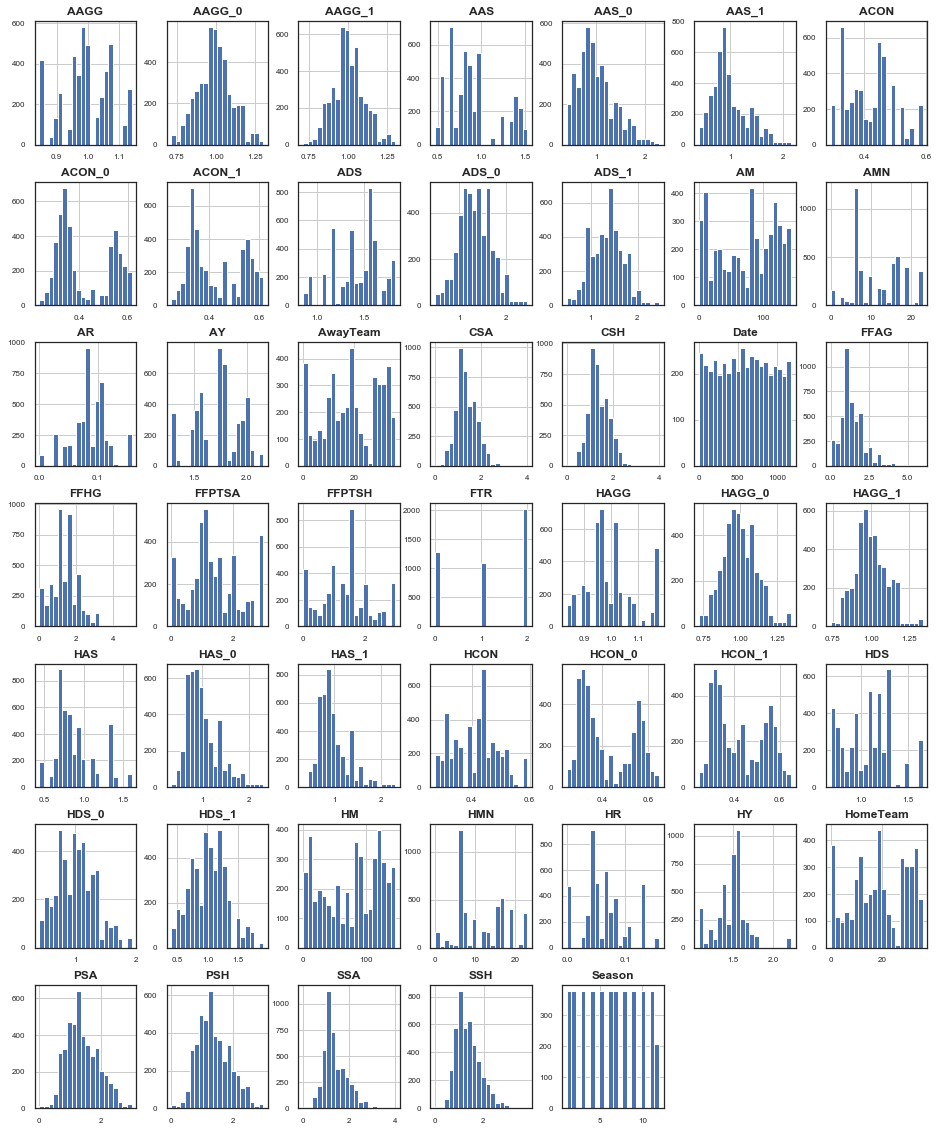

In [73]:
data_for_cor = X.copy()
data_for_cor['FTR'] = y
sns.set_style("white")
data_for_cor.hist(figsize=(16, 20), bins=20, xlabelsize=8, ylabelsize=8)
if(SAVE_IMG):
    fig5=plt.savefig(os.path.join(img_dir,'design_matrix_histogram_1.png'))
plt.show()

#### Correlation plot for Engineered Features

Similar to the correlation matrix plot for the raw column data, this plot visualizes the correlation between the engineered featuers, the competing teams and the full time result. This is represented on a heatmap.

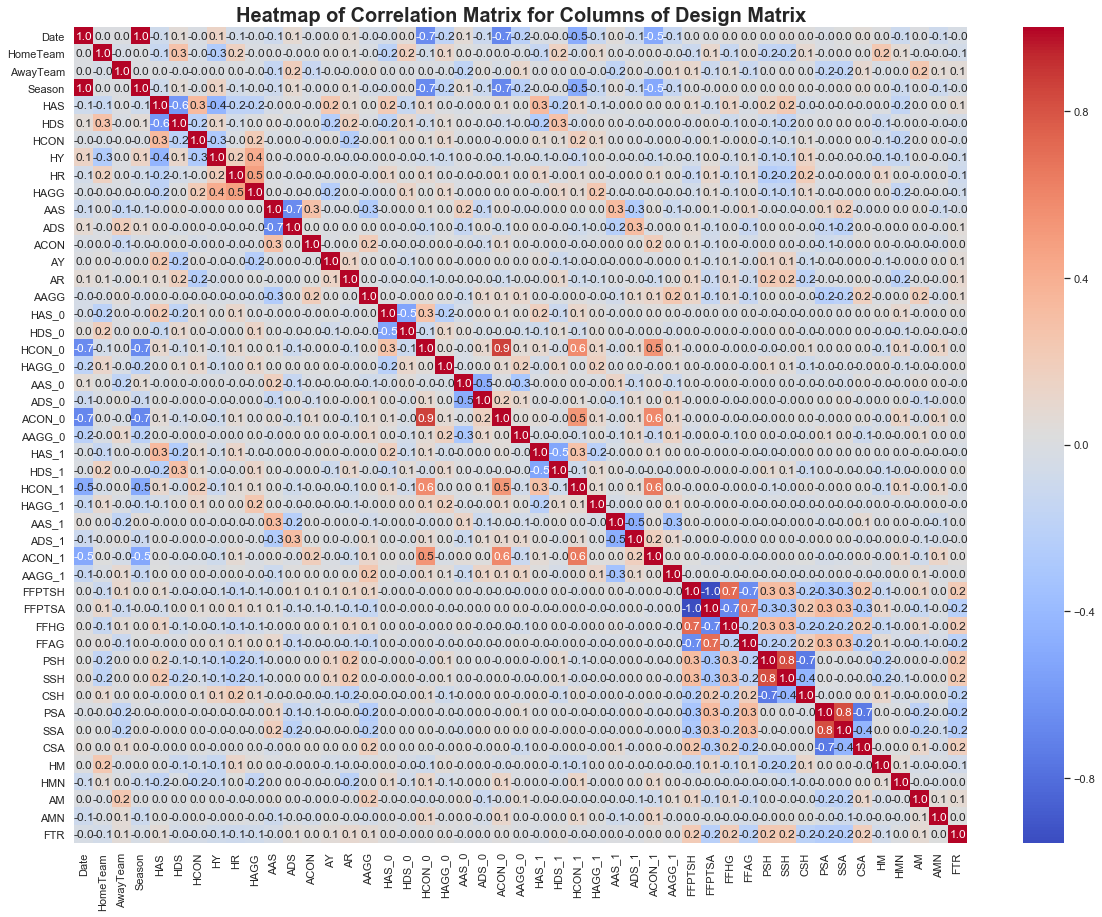

In [74]:
plt.figure(figsize=(20,15))
ax = plt.subplot(111)
ax.set_title("Heatmap of Correlation Matrix for Columns of Design Matrix",
             fontsize=20,fontweight='bold')
sns.heatmap(data_for_cor.corr(), annot = True, fmt='.1f', cmap= 'coolwarm', 
            ax=ax)
if(SAVE_IMG):
    fig6=plt.savefig(os.path.join(img_dir,'X_corr_heatmap.png'))
plt.show()


### Scaling the features

In [75]:
X[X.columns] =MinMaxScaler().fit_transform(X[X.columns])

In [76]:
X.head()

,Date,HomeTeam,AwayTeam,Season,HAS,HDS,HCON,HY,HR,HAGG,AAS,ADS,ACON,AY,AR,AAGG,HAS_0,HDS_0,HCON_0,HAGG_0,AAS_0,ADS_0,ACON_0,AAGG_0,HAS_1,HDS_1,HCON_1,HAGG_1,AAS_1,ADS_1,ACON_1,AAGG_1,FFPTSH,FFPTSA,FFHG,FFAG,PSH,SSH,CSH,PSA,SSA,CSA,HM,HMN,AM,AMN
0,0.0,0.000000,0.916667,0.0,0.771629,0.056420,0.620859,0.382400,0.431818,0.382530,0.714638,0.480703,0.250107,0.772061,0.633333,0.509976,0.509561,0.219282,0.559051,0.392699,0.435568,0.427948,0.338130,0.476075,0.509561,0.220455,0.559051,0.381079,0.472424,0.422170,0.320006,0.476075,0.54348,0.373965,0.310458,0.196134,0.54348,0.408497,0.294201,0.54348,0.388072,0.294201,0.082192,0.304348,0.979167,0.260870
1,0.0,0.138889,0.777778,0.0,0.276591,0.441534,0.523751,0.392088,0.430041,0.541013,0.063338,0.909091,0.145344,0.578331,0.664609,0.501855,0.215837,0.464112,0.482700,0.480364,0.070922,0.640000,0.255709,0.472000,0.215837,0.466594,0.482700,0.471595,0.076923,0.636364,0.235327,0.472000,0.54348,0.373965,0.310458,0.196134,0.54348,0.408497,0.294201,0.54348,0.388072,0.294201,0.342466,0.260870,0.986111,1.000000
2,0.0,0.333333,0.083333,0.0,0.174349,0.102648,0.683125,0.439634,0.500000,0.370107,0.873098,0.082438,0.458949,0.517241,0.500000,0.333681,0.155172,0.248670,0.608007,0.385827,0.524285,0.230807,0.502433,0.387600,0.155172,0.250000,0.608007,0.373984,0.568648,0.223037,0.488808,0.387600,0.54348,0.373965,0.310458,0.196134,0.54348,0.408497,0.294201,0.54348,0.388072,0.294201,0.232877,0.739130,0.736111,0.260870
3,0.0,0.416667,0.361111,0.0,0.334170,0.332738,0.799783,0.451165,0.333333,1.000000,0.487277,0.428364,0.100243,0.321121,0.416667,0.753462,0.250000,0.394947,0.699728,0.734252,0.308274,0.402040,0.220226,0.598272,0.250000,0.397059,0.699728,0.733740,0.334359,0.396000,0.198873,0.598272,0.54348,0.373965,0.310458,0.196134,0.54348,0.408497,0.294201,0.54348,0.388072,0.294201,0.773973,0.260870,0.847222,0.260870
4,0.0,0.555556,0.861111,0.0,0.493990,1.000000,0.805183,0.070652,0.000000,0.669039,0.181568,0.754545,0.308306,0.094828,1.000000,0.798351,0.344828,0.819149,0.703974,0.551181,0.137116,0.563500,0.383917,0.620800,0.344828,0.823529,0.703974,0.544715,0.148718,0.559091,0.367046,0.620800,0.54348,0.373965,0.310458,0.196134,0.54348,0.408497,0.294201,0.54348,0.388072,0.294201,0.328767,0.260870,0.458333,0.826087


### Splitting into training and testing datasets

Splitting the full list of input features into training and testing datasets. The output labels are also split accordingly. The decided splitting ratio is 1:4 (test:train).

In [77]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model Training

#### Functions to train the classifiers

In [132]:
def get_scores(model,X,y):
    score_list=['accuracy','precision_macro','recall_macro','f1_macro','roc_auc_ovr']
    scores = cross_validate(model, X, y, scoring=score_list,
                            cv=10, return_train_score=True,n_jobs=n_cpu)
    mean_scores=[]
    for suffix in score_list:
        mean_scores.append((scores['test_%s'%(suffix)].mean()))
    return scores,mean_scores

In [133]:
def get_model_accuracy_on_test(model,X_train,y_train,X_test,y_test,title):    
    scores = {}
    
    classifier=model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    
    scores['accuracy'] = (accuracy_score(y_test, y_pred))
    scores['precision'] = (precision_score(y_test, y_pred,average='macro'))
    scores['recall'] = (recall_score(y_test, y_pred,average='macro'))
    disp = plot_confusion_matrix(classifier, X_test, y_test,
                                 display_labels=['A','D','H'],
                                 cmap=plt.cm.Blues)
    disp.ax_.set_title('Confusion Matrix: %s'%(title))
    disp.confusion_matrix
    
#     if(SAVE_IMG):
#         CODE TO SAVE FIGURE
#         disp.savefig(os.path.join(img_dir,'confusion_matrix_' + title + '.png'))
    return scores

In [134]:
def get_best_params_RandomizedCV(model,X,y,param_grid,refit='accuracy'):
    scoring=('accuracy','f1_macro','roc_auc_ovr')
    other_scores=[score for score in list(scoring) if score!=refit] 
    grid_results = RandomizedSearchCV(model, param_grid, 
                                       cv=10,n_jobs=n_cpu,
                                       scoring=scoring,
                                       refit=refit)
    grid_results.fit(X, y)
#     print('Best parameters: \n',grid_results.best_params_)
    cv_results=grid_results.cv_results_
    best_index_results = np.nonzero(cv_results['rank_test_%s'%(refit)] == 1)[0][0]
    refit_score=grid_results.best_score_
    other_score_0=cv_results['mean_test_%s'%(other_scores[0])][best_index_results]
    other_score_1=cv_results['mean_test_%s'%(other_scores[1])][best_index_results]
    best_params_df=pd.DataFrame([[refit,refit_score,other_score_0,other_score_1]],
                                columns=['Refit',refit,other_scores[0],other_scores[1]])
    return grid_results.best_params_,best_params_df

In [135]:
def get_best_params_GridCV(model,X,y,param_grid,refit='accuracy'):
    scoring=('accuracy','f1_macro','roc_auc_ovr')
    other_scores=[score for score in list(scoring) if score!=refit] 
    grid_results = GridSearchCV(model, param_grid, 
                                       cv=10,n_jobs=n_cpu,
                                       scoring=scoring,
                                       refit=refit)
    grid_results.fit(X, y)
#     print('Best parameters: \n',grid_results.best_params_)
    cv_results=grid_results.cv_results_
    best_index_results = np.nonzero(cv_results['rank_test_%s'%(refit)] == 1)[0][0]
    refit_score=grid_results.best_score_
    other_score_0=cv_results['mean_test_%s'%(other_scores[0])][best_index_results]
    other_score_1=cv_results['mean_test_%s'%(other_scores[1])][best_index_results]
    best_params_df=pd.DataFrame([[refit,refit_score,other_score_0,other_score_1]],
                                columns=['Refit',refit,other_scores[0],other_scores[1]])
    return grid_results.best_params_,best_params_df

In [136]:
def train_model_get_best_params(model, param_grid, X_train,y_train):
    # Start time measurement
    start_meas = time.time()
    
    # Get cross-val score of the passed model
    scores,scores_list=get_scores(model,X_train,y_train)
    
    # Refit on different score
    # best_params_LR = get_best_model_GridCV(model, X_train, y_train, param_grid, refit='accuracy')
    refit_list=['Accuracy','f1-score','ROC-AUC']
    best_params_a,df_a=get_best_params_RandomizedCV(model, X_train, y_train, param_grid, refit='accuracy')
    best_params_f,df_f=get_best_params_RandomizedCV(model, X_train, y_train, param_grid, refit='f1_macro')
    best_params_r,df_r=get_best_params_RandomizedCV(model, X_train, y_train, param_grid, refit='roc_auc_ovr')
    
    stop_meas=time.time()
    
    # Stop measurement
    training_time=stop_meas-start_meas
    print_exec_time(training_time,'Training time')
        
    # Create a best_params_df
    best_params_df=df_a.append(df_f[df_a.columns], ignore_index=True)
    best_params_df=best_params_df.append(df_r[df_a.columns], ignore_index=True)
    
    # Add mean scores column
    best_params_df['mean']=best_params_df[best_params_df.columns[1:]].mean(axis=1)
    
    # Find the best params
    best_params_list=[best_params_a,best_params_f,best_params_r]
    loc_of_best_params=best_params_df.index[best_params_df['mean']==best_params_df['mean'].max()][0]
    best_params=best_params_list[loc_of_best_params]
    best_scores=best_params_df.iloc[loc_of_best_params]
    
    # Create a scores dataframe
    scores_df=pd.DataFrame([scores_list],columns=['Accuracy','Precision','Recall','f1-score','ROC-AUC'])
    display(HTML('<h4><b>Cross Validation scores on baseline model: </h4></b>'))
    display(scores_df)
    print()
    display(HTML('<h4><b>Scores for different refit on GridSearchCV: </h4></b>'))
    display(best_params_df)
    display(HTML('<h4>\nThe best parameters were for refit = <b>%s</b>.</h4>'%(refit_list[loc_of_best_params])))
    print()
    display(HTML('<b>The best parameters returned are: </b>\n'))
    print(best_params)
    
    return scores,best_scores, best_params

In [137]:
def get_scores_on_reserved_test_data(model,best_params,suffix):
    model.set_params(**best_params)

    test_scores = get_model_accuracy_on_test(model,X_train,y_train,
                                             X_test,y_test,suffix)

    for key, value in test_scores.items():
        print('%s: %f' % (key.capitalize(),value),end='\t')
    print()
    return test_scores

In [138]:
def get_top_features(model,model_name,n=X.shape[1]):
    feature_imp_df = pd.DataFrame({'Features':X.columns})
    if hasattr(model, 'coef_'):
        importances=list(np.sum(np.absolute(model.coef_), axis=0))
        feature_imp_df['Importance']=importances
    elif hasattr(model, 'feature_importances_'):
         feature_imp_df['Importance']=list(model.feature_importances_)
    else:
        print('Attribute required to calculate importance is not available for this model!')
        return None
            
    feature_imp_df = feature_imp_df.sort_values(by=['Importance']).\
                     reset_index(drop=True)
    top_features_imp_df=feature_imp_df.iloc[-n:]
    index=np.arange(n)

    plt.figure()

    plt.barh(index,top_features_imp_df['Importance'], align='center',
             color='brown')
    plt.title('Feature importances: %s'%(model_name),fontsize=18,
              fontweight='bold')
    plt.xlabel('Importance scores',fontsize=16,fontweight='bold')
    plt.ylabel('Features',fontsize=16,fontweight='bold')
    plt.xticks(fontsize=13)
    plt.yticks(index,top_features_imp_df['Features'],fontsize=13)
    plt.ylim([-1, n+1])
    
    if(SAVE_IMG):
        plt.savefig(os.path.join(img_dir,'important_features_' + model_name.replace(" ", "_") + '.png'))
    
    plt.show()

    return feature_imp_df

In [139]:
model_acrnym_list=['LR','MLP','GNB','XGB','RFC','KNN','SGD','SVM']
best_scores_all=[]
all_scores = {}

These are baseline models.

In [140]:
def update_scores_dict(best_scores,suffix):
    model_dict={'Model':suffix}
    model_dict.update(best_scores)
    return model_dict

In [141]:
def plot_cross_val_score_fold_wise(cross_val_scores_dict, plot_name='cross_val_plot'):
    index=np.arange(1,11)
    fig,axs=plt.subplots(5,1,figsize=(8,35))
    for ind,score in zip(np.arange(5),['accuracy','f1_macro','precision_macro','recall_macro','roc_auc_ovr']):
        for key in cross_val_scores_dict.keys():
            axs[ind].plot(index,cross_val_scores_dict[key]['test_%s'%(score)],label=key,marker='.')
        axs[ind].set_xticks(np.arange(1,11))
        axs[ind].legend(fontsize=12)
        axs[ind].set_xlabel('Folds',fontsize=12,fontweight='bold')
        axs[ind].set_ylabel('%s'%(score),fontsize=12,fontweight='bold')
        axs[ind].set_title('Score Comparison: %s'%(score),fontsize=16,fontweight='bold')
    if(SAVE_IMG):
        plt.savefig(os.path.join(img_dir,plot_name.replace(" ", "_") + '.png'))
    plt.show()

In [142]:
def plot_test_scores_for_models(all_scores, plot_name='test_scores_plot'):
    plot_data = {
        'classifier' : [],
        'accuracy' : [],
        'precision' : [],
        'recall' : []
    }
    scoring_methods = []
    for classifier, scores in all_scores.items():
        plot_data['classifier'].append(classifier)
        for scoring, value in scores.items():
            if not scoring in scoring_methods:
                scoring_methods.append(scoring)
            plot_data[scoring].append(value)
    n = len(plot_data['classifier'])
    ind = np.arange(n) 
    colours = ['SkyBlue','IndianRed','GoldenRod']
    fig, ax = plt.subplots()
    for idx in np.arange(len(scoring_methods)): 
        ax.plot(ind , plot_data[scoring_methods[idx]],
                color=colours[idx], label=scoring_methods[idx],marker='.')
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Scores')
    ax.set_title('Scores by classifier')
    ax.set_xticks(ind)
    ax.set_xticklabels(plot_data['classifier'])
    ax.legend()
    if(SAVE_IMG):
        plt.savefig(os.path.join(img_dir,plot_name.replace(" ", "_") + '.png'))
    plt.show()

### Logistic Regression

#### Define model and parameter grid

In [143]:
# Define model and param grid
model_LR = LogisticRegression(n_jobs=n_cpu)

param_grid_LR = {'penalty' : ['l1','l2', 'elasticnet'],
                 'C' : np.logspace(-4,4,10),
                 'class_weight' : ['balanced',None],
                 'solver' : ['newton-cg', 'sag','saga', 'lbfgs'],
                 'fit_intercept' : [True, False]
                }
# Train and get best parameters
scores_LR, best_scores_LR, best_params_LR=train_model_get_best_params(model_LR, param_grid_LR, X_train,y_train)
# Update scores dictionary
best_scores_all.append(update_scores_dict(best_scores_LR,'LR'))

Training time: 12.86s


,Accuracy,Precision,Recall,f1-score,ROC-AUC
0,0.518382,0.431336,0.441142,0.394615,0.639782


,Refit,accuracy,f1_macro,roc_auc_ovr,mean
0,accuracy,0.520939,0.380215,0.639806,0.513653
1,f1_macro,0.472814,0.435494,0.629063,0.512457
2,roc_auc_ovr,0.515822,0.398741,0.641253,0.518605


{'solver': 'newton-cg', 'penalty': 'l2', 'fit_intercept': False, 'class_weight': None, 'C': 21.54434690031882}


#### Getting scores on reserved test dataset

Accuracy: 0.514806	Precision: 0.461190	Recall: 0.425969	


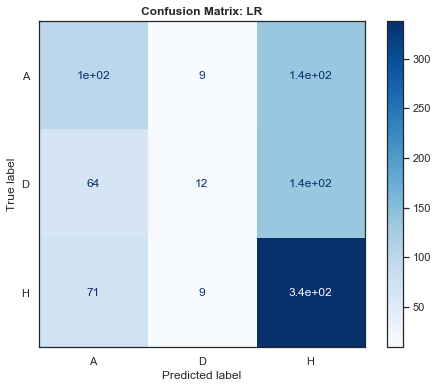

In [144]:
all_scores['LR']=get_scores_on_reserved_test_data(model_LR,best_params_LR,'LR')

#### Checking the top 15 most important features

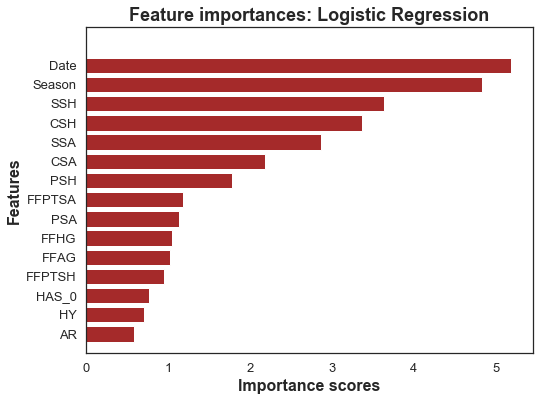

In [145]:
feature_imp_scores_LR=get_top_features(model_LR,'Logistic Regression',n=15)

### Stochastic Gradient Descent

#### Define model and parameter grid

In [146]:
# Define model and param grid
model_SGD = SGDClassifier(loss='log')

param_grid_SGD = {
    'max_iter': [1000000], # not suggested to change! 
    'tol': [1e-3],         # not suggested to change! 
     'loss': ['log', 'modified_huber', 'log', 'modified_huber'],
    'alpha' : np.logspace(-4,4,7),
    'penalty' : ['l1', 'l2']
}
# Train and get best parameters
scores_SGD, best_scores_SGD, best_params_SGD=train_model_get_best_params(model_SGD, param_grid_SGD, X_train,y_train)
# Update scores dictionary
best_scores_all.append(update_scores_dict(best_scores_SGD,'SGD'))

Training time: 4.86s


,Accuracy,Precision,Recall,f1-score,ROC-AUC
0,0.500999,0.429673,0.431563,0.385837,0.630719


,Refit,accuracy,f1_macro,roc_auc_ovr,mean
0,accuracy,0.521510,0.378314,0.643230,0.514351
1,f1_macro,0.495592,0.393435,0.629740,0.506256
2,roc_auc_ovr,0.516680,0.393811,0.635549,0.515347


{'tol': 0.001, 'penalty': 'l1', 'max_iter': 1000000, 'loss': 'modified_huber', 'alpha': 0.002154434690031882}


#### Getting scores on reserved test dataset

Accuracy: 0.514806	Precision: 0.496031	Recall: 0.437159	


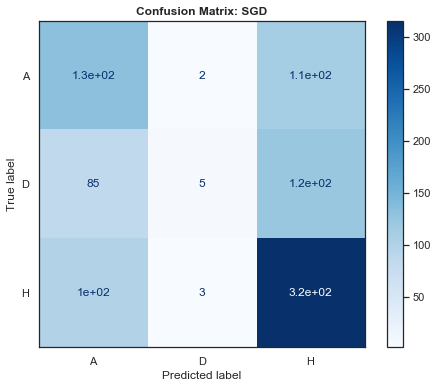

In [147]:
all_scores['SGD']=get_scores_on_reserved_test_data(model_SGD,best_params_SGD,'SGD')

#### Checking the top 15 most important features

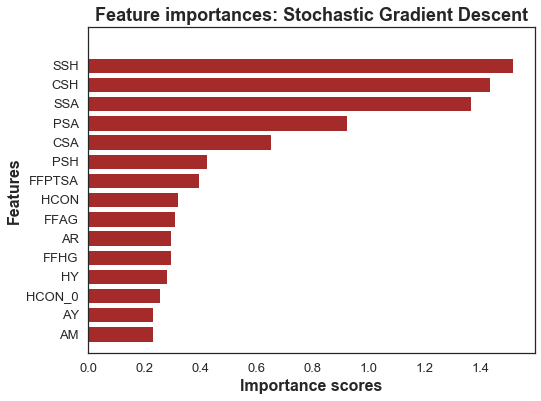

In [148]:
feature_imp_scores_SGD=get_top_features(model_SGD,'Stochastic Gradient Descent', n=15)

### Gaussian Naive Bayes

#### Define model and parameter grid

In [149]:
model_GNB = GaussianNB()

param_grid_GNB = {
    'var_smoothing': np.linspace(0.01,0.199,25)
}

# Train and get best parameters
scores_GNB, best_scores_GNB, best_params_GNB=train_model_get_best_params(model_GNB, param_grid_GNB, X_train,y_train)
# Update scores dictionary
best_scores_all.append(update_scores_dict(best_scores_GNB,'GNB'))

Training time: 1.62s


,Accuracy,Precision,Recall,f1-score,ROC-AUC
0,0.497296,0.452547,0.458663,0.447429,0.652636


,Refit,accuracy,f1_macro,roc_auc_ovr,mean
0,accuracy,0.497302,0.437473,0.647961,0.527578
1,f1_macro,0.496726,0.446670,0.652386,0.531927
2,roc_auc_ovr,0.495017,0.444408,0.652001,0.530476


{'var_smoothing': 0.01}


#### Getting scores on reserved test dataset

Accuracy: 0.507973	Precision: 0.461944	Recall: 0.463841	


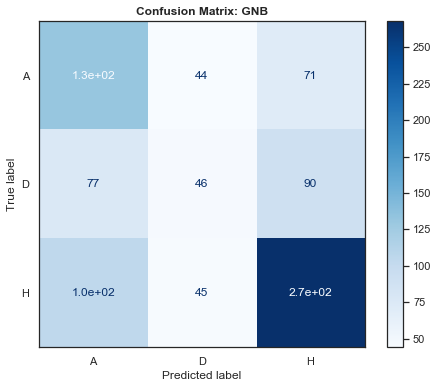

In [150]:
all_scores['GNB']=get_scores_on_reserved_test_data(model_GNB,best_params_GNB,'GNB')

#### Checking the top 15 most important features

In [151]:
feature_imp_scores_GNB=get_top_features(model_GNB,'Gaussian Naive Bayes',n=15)

Attribute required to calculate importance is not available for this model!


### k-Nearest Neighbours

#### Define model and parameter grid

In [152]:
# Define model and param grid
model_KNN = KNeighborsClassifier()

param_grid_KNN = {
    'n_neighbors': range(1,10),
    'weights': ['distance', 'uniform'],
    'algorithm': ['ball_tree', 'kd_tree','brute']
}

# Train and get best parameters
scores_KNN, best_scores_KNN, best_params_KNN=train_model_get_best_params(model_KNN, param_grid_KNN, X_train,y_train)
# Update scores dictionary
best_scores_all.append(update_scores_dict(best_scores_KNN,'KNN'))

Training time: 20.78s


,Accuracy,Precision,Recall,f1-score,ROC-AUC
0,0.440045,0.404163,0.408869,0.402676,0.580386


,Refit,accuracy,f1_macro,roc_auc_ovr,mean
0,accuracy,0.462829,0.405400,0.592412,0.486880
1,f1_macro,0.474514,0.416929,0.601184,0.497542
2,roc_auc_ovr,0.474514,0.416929,0.601184,0.497542


{'weights': 'uniform', 'n_neighbors': 9, 'algorithm': 'ball_tree'}


#### Getting scores on reserved test dataset

Accuracy: 0.472665	Precision: 0.422353	Recall: 0.424147	


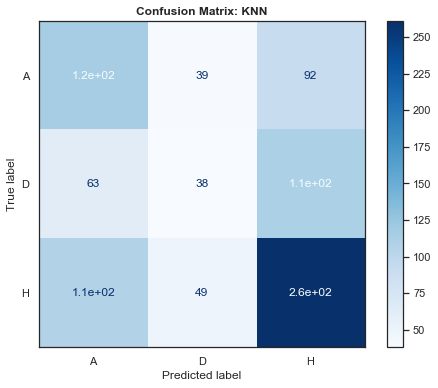

In [153]:
all_scores['KNN']=get_scores_on_reserved_test_data(model_KNN,best_params_KNN,
                                                   'KNN')

#### Checking the top 15 most important features

In [154]:
feature_imp_scores_KNN=get_top_features(model_KNN,
                                        'k-Nearest Neighbours Classifier',
                                        n=15)

Attribute required to calculate importance is not available for this model!


### Support Vector Machine

#### Define model and parameter grid

In [155]:
# Define model and param grid
model_SVM = SVC(probability=True)

param_grid_SVM = {
        'kernel':['linear', 'rbf', 'sigmoid',],
        'degree':range(2,5),
        'gamma':['scale', 'auto'],
        'shrinking': [True, False],
        'probability': [True], # It has to be True, False will trigger error for the algorithm
        'decision_function_shape': ['ovo', 'ovr'],
    }

# Train and get best parameters
scores_SVM, best_scores_SVM, best_params_SVM=train_model_get_best_params(model_SVM, param_grid_SVM, X_train,y_train)
# Update scores dictionary
best_scores_all.append(update_scores_dict(best_scores_SVM,'SVM'))

Training time: 11min 58s


,Accuracy,Precision,Recall,f1-score,ROC-AUC
0,0.514101,0.427933,0.43195,0.387864,0.620269


,Refit,accuracy,f1_macro,roc_auc_ovr,mean
0,accuracy,0.519238,0.377165,0.620933,0.505779
1,f1_macro,0.519238,0.377165,0.620376,0.505593
2,roc_auc_ovr,0.516098,0.361677,0.628737,0.502170


{'shrinking': False, 'probability': True, 'kernel': 'linear', 'gamma': 'auto', 'degree': 2, 'decision_function_shape': 'ovr'}


#### Getting scores on reserved test dataset

Accuracy: 0.517084	Precision: 0.330216	Recall: 0.417801	


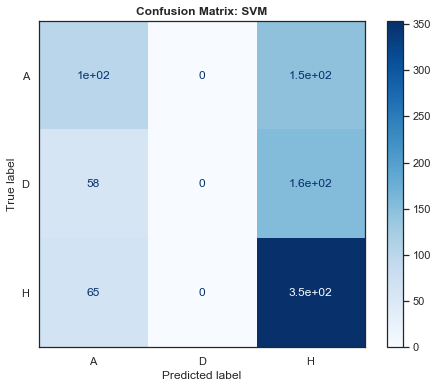

In [156]:
all_scores['SVM']=get_scores_on_reserved_test_data(model_SVM,best_params_SVM, 'SVM')

#### Checking the top 15 most important features

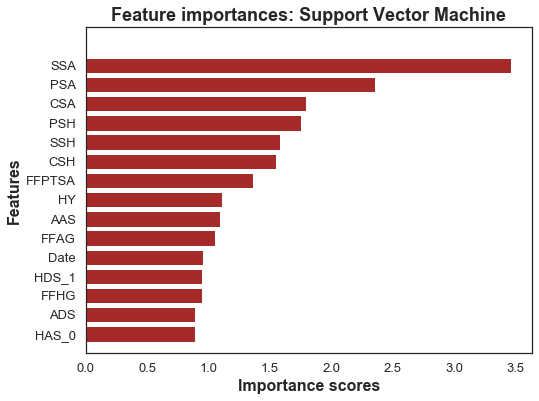

In [157]:
feature_imp_scores_SVM=get_top_features(model_SVM,'Support Vector Machine',n=15)

### Decision Tree Classifier

#### Define model and parameter grid

In [158]:
# Define model and param grid
model_DTC = DecisionTreeClassifier()

param_grid_DTC = {'min_samples_split':[2],
                  'min_samples_leaf':[1], 
                  'min_weight_fraction_leaf':[0.0], 
                  'max_features':[5], 
                  'random_state':[0], 
                  'max_leaf_nodes':[10]
                 }

# Train and get best parameters
scores_DTC, best_scores_DTC, best_params_DTC=train_model_get_best_params(model_DTC, param_grid_DTC, X_train,y_train)
# Update scores dictionary
best_scores_all.append(update_scores_dict(best_scores_DTC,'DTC'))

Training time: 0.74s


,Accuracy,Precision,Recall,f1-score,ROC-AUC
0,0.407292,0.381299,0.381134,0.380565,0.53787


,Refit,accuracy,f1_macro,roc_auc_ovr,mean
0,accuracy,0.491032,0.3695,0.603392,0.487975
1,f1_macro,0.491032,0.3695,0.603392,0.487975
2,roc_auc_ovr,0.491032,0.3695,0.603392,0.487975


{'random_state': 0, 'min_weight_fraction_leaf': 0.0, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_leaf_nodes': 10, 'max_features': 5}


#### Getting scores on reserved test dataset

Accuracy: 0.497722	Precision: 0.426880	Recall: 0.421426	


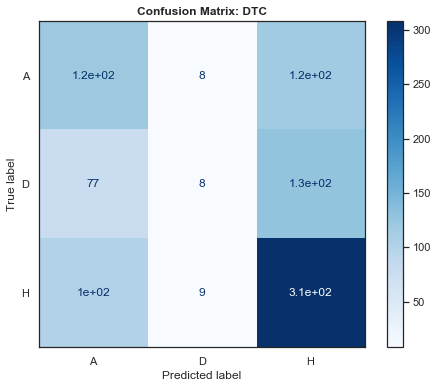

In [159]:
all_scores['DTC']=get_scores_on_reserved_test_data(model_DTC,best_params_DTC,'DTC')

#### Checking the top 15 most important features

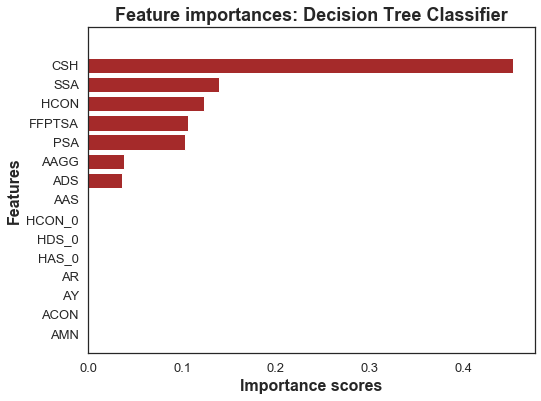

In [160]:
feature_imp_scores_DTC=get_top_features(model_DTC,'Decision Tree Classifier',n=15)

### Random Forests Classifier

#### Define model and parameter grid

In [161]:
# Define model and param grid
model_RFC = RandomForestClassifier()

param_grid_RFC = {
    'bootstrap': [True, False],
    'max_depth': np.append(np.linspace(10,100,10,dtype = int),None),
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': np.linspace(2,5,3,dtype = int),
    'min_samples_split': np.linspace(2,10,3,dtype = int),
    'n_estimators': np.linspace(200,2000,10,dtype = int)
}

# Train and get best parameters
scores_RFC, best_scores_RFC, best_params_RFC=train_model_get_best_params(model_RFC, param_grid_RFC, X_train,y_train)
# Update scores dictionary
best_scores_all.append(update_scores_dict(best_scores_RFC,'RFC'))

Training time: 21min 36s


,Accuracy,Precision,Recall,f1-score,ROC-AUC
0,0.509551,0.444636,0.441663,0.420463,0.637987


,Refit,accuracy,f1_macro,roc_auc_ovr,mean
0,accuracy,0.527495,0.411035,0.652134,0.530221
1,f1_macro,0.513257,0.423469,0.646653,0.527793
2,roc_auc_ovr,0.526072,0.410465,0.653748,0.530095


{'n_estimators': 600, 'min_samples_split': 6, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'max_depth': 80, 'bootstrap': True}


#### Getting scores on reserved test dataset

Accuracy: 0.515945	Precision: 0.431131	Recall: 0.422592	


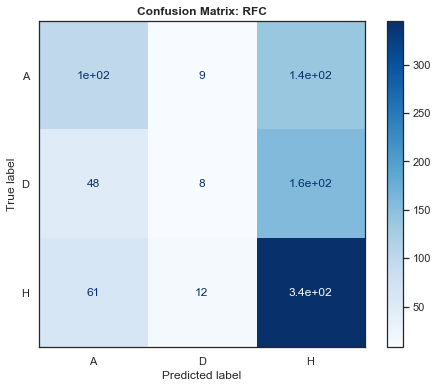

In [162]:
all_scores['RFC']=get_scores_on_reserved_test_data(model_RFC,best_params_RFC,'RFC')

#### Checking the top 15 most important features

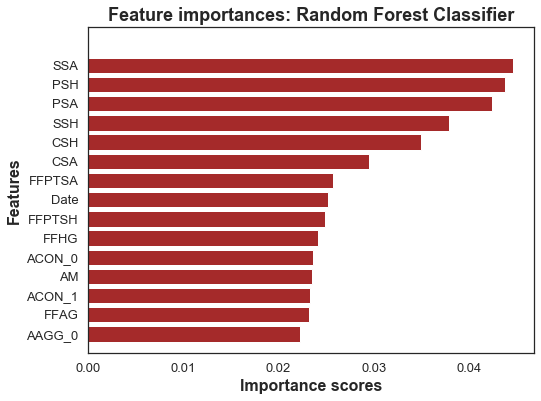

In [163]:
feature_imp_scores_RFC=get_top_features(model_RFC,'Random Forest Classifier',n=15)

### Extra Trees Classifier

#### Define model and parameter grid

In [164]:
# Define model and param grid
model_ETC = ExtraTreesClassifier()

param_grid_ETC = {'min_samples_leaf':[1],'min_weight_fraction_leaf':[0.0], 
                      'max_features':['auto'], 'max_leaf_nodes':[None], 'min_impurity_decrease':[0.0],
                      'min_impurity_split':[None]
                     }

# Train and get best parameters
scores_ETC, best_scores_ETC, best_params_ETC=train_model_get_best_params(model_ETC, param_grid_ETC, X_train,y_train)
# Update scores dictionary
best_scores_all.append(update_scores_dict(best_scores_ETC,'ETC'))

Training time: 12.05s


,Accuracy,Precision,Recall,f1-score,ROC-AUC
0,0.510684,0.448148,0.446532,0.429163,0.642636


,Refit,accuracy,f1_macro,roc_auc_ovr,mean
0,accuracy,0.499291,0.412355,0.638444,0.516697
1,f1_macro,0.501000,0.414298,0.644291,0.519863
2,roc_auc_ovr,0.504707,0.420184,0.639253,0.521381


{'min_weight_fraction_leaf': 0.0, 'min_samples_leaf': 1, 'min_impurity_split': None, 'min_impurity_decrease': 0.0, 'max_leaf_nodes': None, 'max_features': 'auto'}


#### Getting scores on reserved test dataset

Accuracy: 0.521640	Precision: 0.476699	Recall: 0.451382	


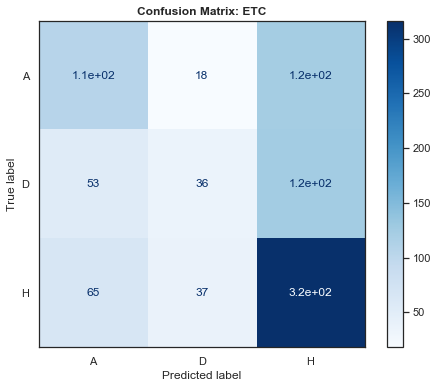

In [165]:
all_scores['ETC']=get_scores_on_reserved_test_data(model_ETC,best_params_ETC,'ETC')

#### Checking the top 15 most important features

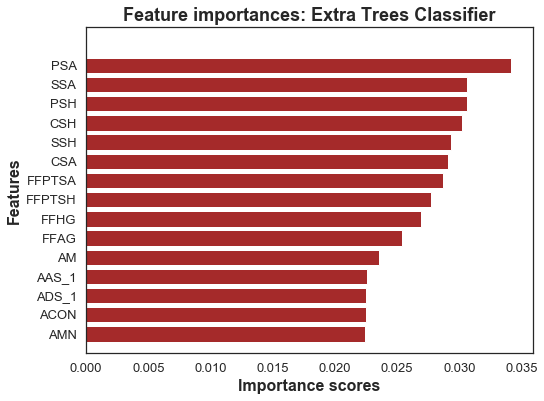

In [166]:
feature_imp_scores_ETC=get_top_features(model_ETC,'Extra Trees Classifier',n=15)

### Multi-Layer Perceptron Neural Network

#### Define model and parameter grid

In [167]:
# Define model and param grid
model_MLP = MLPClassifier()

param_grid_MLP = {
#     'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    'activation': ['tanh', 'relu','logistic'],
    'solver': ['sgd', 'adam'],
    'alpha': np.linspace(0.0001, 0.9,5),
    'learning_rate': ['constant','adaptive'],
}

# Train and get best parameters
scores_MLP, best_scores_MLP, best_params_MLP=train_model_get_best_params(model_MLP, param_grid_MLP, X_train,y_train)
# Update scores dictionary
best_scores_all.append(update_scores_dict(best_scores_MLP,'MLP'))

Training time: 9min 31s


,Accuracy,Precision,Recall,f1-score,ROC-AUC
0,0.474506,0.418984,0.422076,0.413539,0.615339


,Refit,accuracy,f1_macro,roc_auc_ovr,mean
0,accuracy,0.519230,0.373039,0.645521,0.512597
1,f1_macro,0.476501,0.410583,0.614801,0.500628
2,roc_auc_ovr,0.519229,0.378074,0.646026,0.514443


{'solver': 'adam', 'learning_rate': 'adaptive', 'alpha': 0.225075, 'activation': 'logistic'}


#### Getting scores on reserved test dataset

Accuracy: 0.501139	Precision: 0.316998	Recall: 0.412158	


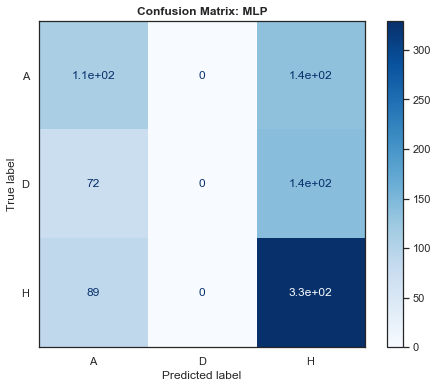

In [168]:
all_scores['MLP']=get_scores_on_reserved_test_data(model_MLP,best_params_MLP,'MLP')

#### Checking the top 15 most important features

In [169]:
feature_imp_scores_MLP=get_top_features(model_MLP,
                                'Multi-Layer Perceptron Neural Network',n=15)

Attribute required to calculate importance is not available for this model!


### XGBoost

#### Define model and parameter grid

In [170]:
# Define model and param grid
model_XGB = XGBClassifier(nthread=n_cpu)

param_grid_XGB = {'min_child_weight': [1, 5, 10],
                  'gamma': [0.5, 1, 1.5, 2, 5],
                  'subsample': [0.6, 0.8, 1.0],
                  'colsample_bytree': [0.6, 0.8, 1.0],
                  'max_depth': [3, 4, 5]
                 }

# Train and get best parameters
scores_XGB, best_scores_XGB, best_params_XGB=train_model_get_best_params(model_XGB, param_grid_XGB, X_train,y_train)
# Update scores dictionary
best_scores_all.append(update_scores_dict(best_scores_XGB,'XGB'))

Training time: 3min 46s


,Accuracy,Precision,Recall,f1-score,ROC-AUC
0,0.517809,0.451531,0.443493,0.413467,0.646903


,Refit,accuracy,f1_macro,roc_auc_ovr,mean
0,accuracy,0.517233,0.422753,0.644271,0.528086
1,f1_macro,0.501571,0.427459,0.638331,0.522454
2,roc_auc_ovr,0.518097,0.390961,0.650834,0.519964


{'subsample': 1.0, 'min_child_weight': 1, 'max_depth': 4, 'gamma': 1.5, 'colsample_bytree': 1.0}


#### Getting scores on reserved test dataset

Accuracy: 0.531891	Precision: 0.484587	Recall: 0.450668	


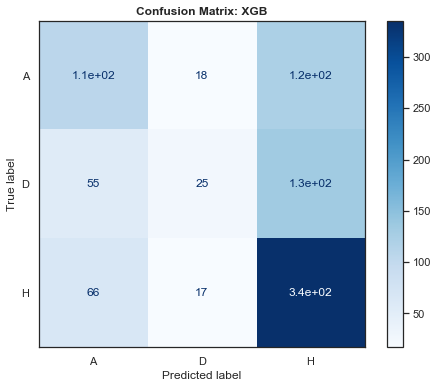

In [171]:
all_scores['XGB']=get_scores_on_reserved_test_data(model_XGB,best_params_XGB,'XGB')

#### Checking the top 15 most important features

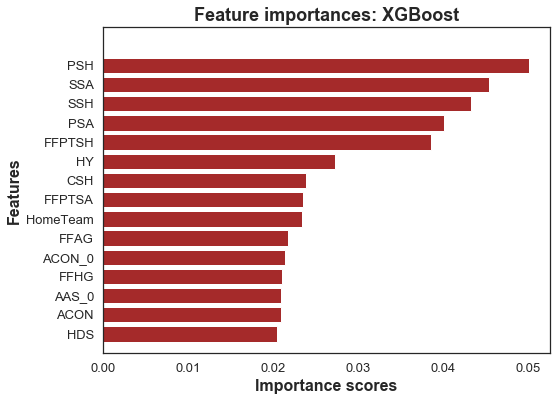

In [172]:
feature_imp_scores_XGB=get_top_features(model_XGB,'XGBoost',n=15)

### Plotting Scores for all Classifiers

In [173]:
cross_val_scores_dict={'LR':scores_LR,'SGD':scores_SGD,'GNB':scores_GNB,'k-NN':scores_KNN,'SVM':scores_SVM,
                       'DTC':scores_DTC, 'RFC':scores_RFC, 'ETC':scores_ETC,'MLP':scores_MLP, 'XGB':scores_XGB}

#### Comparing Model Evaluation Metrics in each fold of the cross-validation 

These are the scores for the baseline models before hyperparameter tuning.

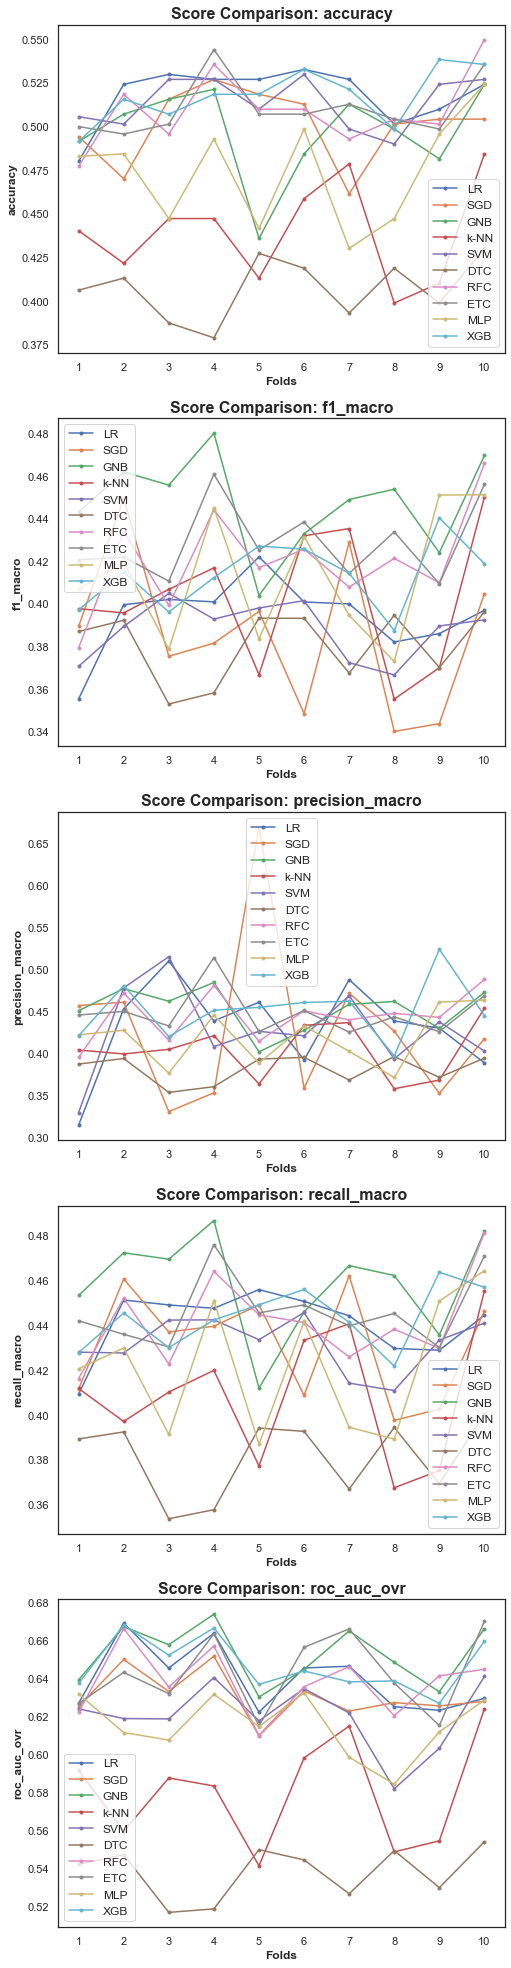

In [174]:
plot_cross_val_score_fold_wise(cross_val_scores_dict)

#### Accuracy on reserved test dataset from the training data

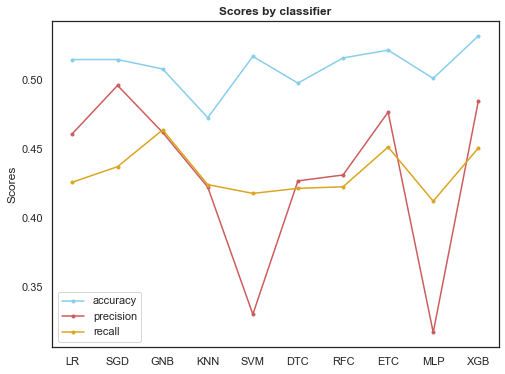

In [175]:
plot_test_scores_for_models(all_scores)

## Feature Selection

In [176]:
def perform_PCA(data_train,data_test=None,n_components=1,disp_plot=False):
    pca = PCA(n_components=n_components).fit(data_train)
    
    data_train_reduced=pca.transform(data_train)
    display(HTML('Dimensionality of data has been reduced from <b>%d to %d</b>.'%(data_train.shape[1],
                                                                   data_train_reduced.shape[1])))
    # Plot the explained ratios
    if disp_plot:
        pca_full=PCA().fit(data_train)
        sns.set_style('white')
        ratio_cumsum=np.cumsum(pca_full.explained_variance_ratio_)
        plt.plot(np.arange(len(ratio_cumsum)),ratio_cumsum)
        plt.axvline(x=data_train_reduced.shape[1],linestyle='--',color='r',
                    ymax=0.95)
        plt.axhline(y=1,linestyle='--',color='#A9A9A9',
                    xmax=0.95)
        plt.xlabel('Number of components')
        plt.ylabel('Cumulative explained variance');
        plt.title('Cumulative explained variance ratio vs. Number of components')
        
        if(SAVE_IMG):
            plt.savefig(os.path.join(img_dir,'pca_variance_ratio.png'))
        
        plt.show()
    # Return reduced dataframes
    if data_test is None:
        return data_train_reduced
    else:
        return data_train_reduced, pca.transform(data_test)

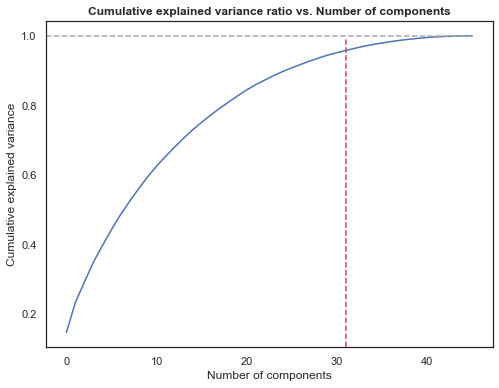

In [177]:
X_train_red,X_test_red=perform_PCA(X_train,data_test=X_test,n_components=0.95, disp_plot=True)

In [178]:
X_train_red.shape

(3511, 31)

## Re-train models

In [179]:
best_scores_all_red=[]
all_scores_red = {}

### Logistic Regression

#### Define model and parameter grid

In [180]:
# Define model and param grid
model_LR_red = LogisticRegression(n_jobs=n_cpu)

param_grid_LR_red = {'penalty' : ['l1','l2', 'elasticnet'],
                 'C' : np.logspace(-4,4,10),
                 'class_weight' : ['balanced',None],
                 'solver' : ['newton-cg', 'sag','saga', 'lbfgs'],
                 'fit_intercept' : [True, False]
                }
# Train and get best parameters
scores_LR_red, best_scores_LR_red, best_params_LR_red=train_model_get_best_params(model_LR_red, param_grid_LR_red, X_train_red,y_train)
# Update scores dictionary
best_scores_all_red.append(update_scores_dict(best_scores_LR_red,'LR'))

Training time: 5.78s


,Accuracy,Precision,Recall,f1-score,ROC-AUC
0,0.522077,0.440076,0.443993,0.393971,0.641266


,Refit,accuracy,f1_macro,roc_auc_ovr,mean
0,accuracy,0.521223,0.394578,0.641107,0.518969
1,f1_macro,0.482496,0.439982,0.637678,0.520052
2,roc_auc_ovr,0.489048,0.434346,0.642680,0.522025


{'solver': 'newton-cg', 'penalty': 'l2', 'fit_intercept': False, 'class_weight': None, 'C': 0.3593813663804626}


#### Getting scores on reserved test dataset

Accuracy: 0.514806	Precision: 0.530597	Recall: 0.424003	


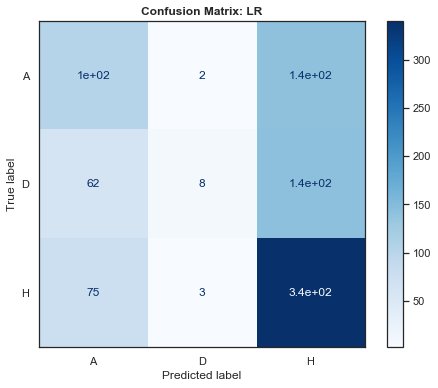

In [181]:
all_scores_red['LR']=get_scores_on_reserved_test_data(model_LR_red,best_params_LR_red,'LR')

#### Checking the top 15 most important features

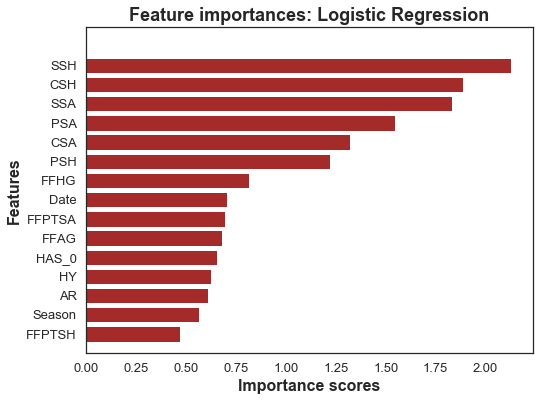

In [182]:
feature_imp_scores_LR_red=get_top_features(model_LR_red,'Logistic Regression',n=15)

### Stochastic Gradient Descent

#### Define model and parameter grid

In [183]:
# Define model and param grid
model_SGD_red = SGDClassifier(loss='log')

param_grid_SGD_red = {
    'max_iter': [1000000], # not suggested to change! 
    'tol': [1e-3],         # not suggested to change! 
     'loss': ['log', 'modified_huber', 'log', 'modified_huber'],
    'alpha' : np.logspace(-4,4,7),
    'penalty' : ['l1', 'l2']
}
# Train and get best parameters
scores_SGD_red, best_scores_SGD_red, best_params_SGD_red=train_model_get_best_params(model_SGD_red, param_grid_SGD_red, X_train_red,y_train)
# Update scores dictionary
best_scores_all_red.append(update_scores_dict(best_scores_SGD_red,'SGD'))

Training time: 4.44s


,Accuracy,Precision,Recall,f1-score,ROC-AUC
0,0.5087,0.423777,0.439933,0.399148,0.629778


,Refit,accuracy,f1_macro,roc_auc_ovr,mean
0,accuracy,0.519516,0.380663,0.636324,0.512168
1,f1_macro,0.518377,0.384691,0.633409,0.512159
2,roc_auc_ovr,0.514389,0.384937,0.633457,0.510928


{'tol': 0.001, 'penalty': 'l2', 'max_iter': 1000000, 'loss': 'log', 'alpha': 0.002154434690031882}


#### Getting scores on reserved test dataset

Accuracy: 0.502278	Precision: 0.483990	Recall: 0.410410	


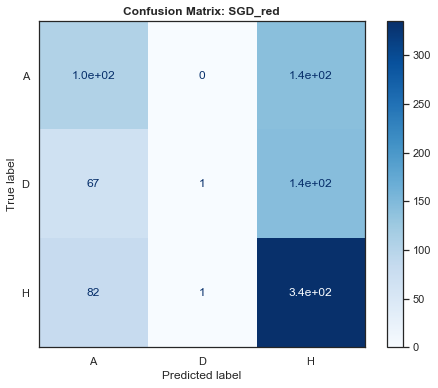

In [184]:
all_scores_red['SGD_red']=get_scores_on_reserved_test_data(model_SGD_red,best_params_SGD_red,
                                                   'SGD_red')

#### Checking the top 15 most important features

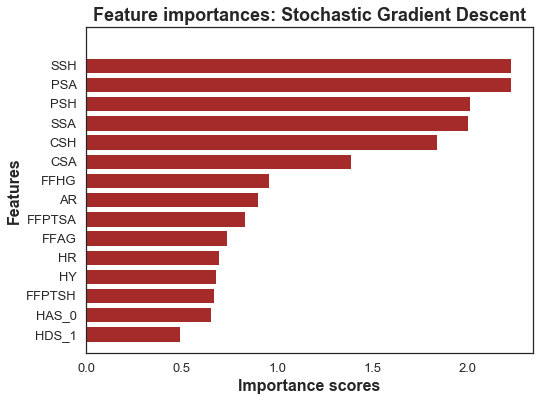

In [185]:
feature_imp_scores_SGD_red=get_top_features(model_SGD_red,'Stochastic Gradient Descent',
                                        n=15)

### Gaussian Naive Bayes

#### Define model and parameter grid

In [186]:
model_GNB_red = GaussianNB()

param_grid_GNB_red = {
    'var_smoothing': np.linspace(0.01,0.199,25)
}

# Train and get best parameters
scores_GNB_red, best_scores_GNB_red, best_params_GNB_red=train_model_get_best_params(model_GNB_red, param_grid_GNB_red, X_train_red,y_train)
# Update scores dictionary
best_scores_all_red.append(update_scores_dict(best_scores_GNB_red,'GNB'))

Training time: 1.62s


,Accuracy,Precision,Recall,f1-score,ROC-AUC
0,0.502431,0.427177,0.435776,0.40588,0.632621


,Refit,accuracy,f1_macro,roc_auc_ovr,mean
0,accuracy,0.517809,0.375747,0.637406,0.510321
1,f1_macro,0.510403,0.388294,0.636929,0.511875
2,roc_auc_ovr,0.511257,0.378969,0.637471,0.509232


{'var_smoothing': 0.033625}


#### Getting scores on reserved test dataset

Accuracy: 0.509112	Precision: 0.462682	Recall: 0.464639	


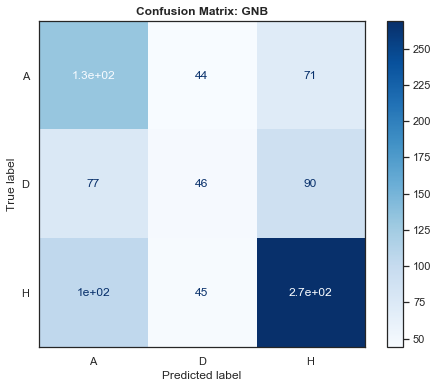

In [187]:
all_scores_red['GNB']=get_scores_on_reserved_test_data(model_GNB_red,best_params_GNB_red,'GNB')

#### Checking the top 15 most important features

In [188]:
feature_imp_scores_GNB_red=get_top_features(model_GNB_red,'Gaussian Naive Bayes',n=15)

Attribute required to calculate importance is not available for this model!


### k-Nearest Neighbours

#### Define model and parameter grid

In [189]:
# Define model and param grid
model_KNN_red = KNeighborsClassifier()

param_grid_KNN_red = {
    'n_neighbors': range(1,10),
    'weights': ['distance', 'uniform'],
    'algorithm': ['ball_tree', 'kd_tree','brute']
}

# Train and get best parameters
scores_KNN_red, best_scores_KNN_red, best_params_KNN_red=train_model_get_best_params(model_KNN_red, param_grid_KNN_red, X_train_red,y_train)
# Update scores dictionary
best_scores_all_red.append(update_scores_dict(best_scores_KNN_red,'KNN'))

Training time: 18.08s


,Accuracy,Precision,Recall,f1-score,ROC-AUC
0,0.440618,0.405024,0.409809,0.403401,0.5818


,Refit,accuracy,f1_macro,roc_auc_ovr,mean
0,accuracy,0.471661,0.410997,0.594389,0.492349
1,f1_macro,0.462267,0.415025,0.594470,0.490587
2,roc_auc_ovr,0.472518,0.409329,0.598587,0.493478


{'weights': 'distance', 'n_neighbors': 9, 'algorithm': 'brute'}


#### Getting scores on reserved test dataset

Accuracy: 0.482916	Precision: 0.436710	Recall: 0.427311	


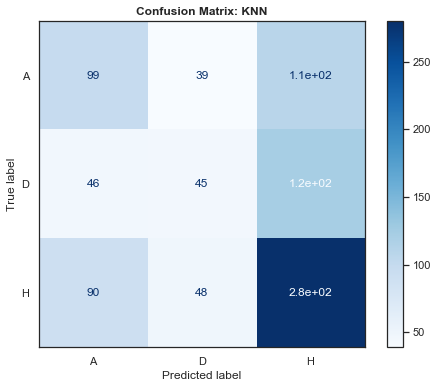

In [190]:
all_scores_red['KNN']=get_scores_on_reserved_test_data(model_KNN_red,best_params_KNN_red,
                                                   'KNN')

#### Checking the top 15 most important features

In [191]:
feature_imp_scores_KNN_red=get_top_features(model_KNN_red,
                                        'k-Nearest Neighbours Classifier',
                                        n=15)

Attribute required to calculate importance is not available for this model!


### Support Vector Machine

#### Define model and parameter grid

In [192]:
# Define model and param grid
model_SVM_red = SVC(gamma='auto',probability = True)

param_grid_SVM_red = {
        'kernel':['linear', 'rbf', 'sigmoid',],
        'degree':range(2,5),
        'gamma':['scale', 'auto'],
        'shrinking': [True, False],
        'decision_function_shape': ['ovo', 'ovr'],
    }

# Train and get best parameters
scores_SVM_red, best_scores_SVM_red, best_params_SVM_red=train_model_get_best_params(model_SVM_red, param_grid_SVM_red, X_train_red,y_train)
# Update scores dictionary
best_scores_all_red.append(update_scores_dict(best_scores_SVM_red,'SVM'))

KeyboardInterrupt: 

#### Getting scores on reserved test dataset

In [ ]:
all_scores_red['SVM']=get_scores_on_reserved_test_data(model_SVM_red,best_params_SVM_red,
                                                   'SVM')

#### Checking the top 15 most important features

In [ ]:
feature_imp_scores_SVM_red=get_top_features(model_SVM_red,'Support Vector Machine',n=15)

### Decision Tree Classifier

#### Define model and parameter grid

In [ ]:
# Define model and param grid
model_DTC_red = DecisionTreeClassifier()

param_grid_DTC_red = {'min_samples_split':[2],
                      'min_samples_leaf':[1], 
                      'min_weight_fraction_leaf':[0.0], 
                      'max_features':[5], 
                      'random_state':[0], 
                      'max_leaf_nodes':[10]
                     }
# Train and get best parameters
scores_DTC_red, best_scores_DTC_red, best_params_DTC_red=train_model_get_best_params(model_DTC_red, param_grid_DTC_red, X_train_red,y_train)
# Update scores dictionary
best_scores_all_red.append(update_scores_dict(best_scores_DTC_red,'DTC'))

#### Getting scores on reserved test dataset

In [ ]:
all_scores_red['DTC']=get_scores_on_reserved_test_data(model_DTC_red,best_params_DTC_red,'DTC')

#### Checking the top 15 most important features

In [ ]:
feature_imp_scores_DTC_red=get_top_features(model_DTC_red,'Decision Tree Classifier',n=15)

### Random Forests Classifier

#### Define model and parameter grid

In [ ]:
# Define model and param grid
model_RFC_red = RandomForestClassifier()

param_grid_RFC_red = {
    'bootstrap': [True, False],
    'max_depth': np.append(np.linspace(10,100,10,dtype = int),None),
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': np.linspace(2,5,3,dtype = int),
    'min_samples_split': np.linspace(2,10,3,dtype = int),
    'n_estimators': np.linspace(200,2000,10,dtype = int)
}

# Train and get best parameters
scores_RFC_red, best_scores_RFC_red, best_params_RFC_red=train_model_get_best_params(model_RFC_red, param_grid_RFC_red, X_train_red,y_train)
# Update scores dictionary
best_scores_all_red.append(update_scores_dict(best_scores_RFC_red,'RFC'))

#### Getting scores on reserved test dataset

In [ ]:
all_scores_red['RFC']=get_scores_on_reserved_test_data(model_RFC_red,best_params_RFC_red,'RFC')

#### Checking the top 15 most important features

In [ ]:
feature_imp_scores_RFC_red=get_top_features(model_RFC_red,'Random Forest Classifier',n=15)

### Extra Trees Classifier

#### Define model and parameter grid

In [ ]:
# Define model and param grid
model_ETC_red = ExtraTreesClassifier()

param_grid_ETC_red = {'min_samples_leaf':[1],'min_weight_fraction_leaf':[0.0], 
                      'max_features':['auto'], 'max_leaf_nodes':[None], 'min_impurity_decrease':[0.0],
                      'min_impurity_split':[None]
                     }

# Train and get best parameters
scores_ETC_red, best_scores_ETC_red, best_params_ETC_red=train_model_get_best_params(model_ETC_red, 
                                                                                param_grid_ETC_red, X_train_red,y_train)
# Update scores dictionary
best_scores_all_red.append(update_scores_dict(best_scores_ETC_red,'ETC'))

#### Getting scores on reserved test dataset

In [ ]:
all_scores_red['ETC']=get_scores_on_reserved_test_data(model_ETC_red,best_params_ETC_red,'ETC')

#### Checking the top 15 most important features

In [ ]:
feature_imp_scores_ETC_red=get_top_features(model_ETC_red,'Extra Trees Classifier',n=15)

### Multi-Layer Perceptron Neural Network

#### Define model and parameter grid

In [ ]:
# Define model and param grid
model_MLP_red = MLPClassifier()

param_grid_MLP_red = {
#     'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    'activation': ['tanh', 'relu','logistic'],
    'solver': ['sgd', 'adam'],
    'alpha': np.linspace(0.0001, 0.9,5),
    'learning_rate': ['constant','adaptive'],
}

# Train and get best parameters
scores_MLP_red, best_scores_MLP_red, best_params_MLP_red=train_model_get_best_params(model_MLP_red, param_grid_MLP_red, X_train_red,y_train)
# Update scores dictionary
best_scores_all_red.append(update_scores_dict(best_scores_MLP_red,'MLP'))

#### Getting scores on reserved test dataset

In [ ]:
all_scores_red['MLP']=get_scores_on_reserved_test_data(model_MLP_red,best_params_MLP_red,'MLP')

#### Checking the top 15 most important features

In [ ]:
feature_imp_scores_MLP_red=get_top_features(model_MLP_red,
                                'Multi-Layer Perceptron Neural Network',n=15)

### XGBoost

#### Define model and parameter grid

In [ ]:
# Define model and param grid
model_XGB_red = XGBClassifier(nthread=n_cpu)

param_grid_XGB_red = {'min_child_weight': [1, 5, 10],
                  'gamma': [0.5, 1, 1.5, 2, 5],
                  'subsample': [0.6, 0.8, 1.0],
                  'colsample_bytree': [0.6, 0.8, 1.0],
                  'max_depth': [3, 4, 5]
                 }

# Train and get best parameters
scores_XGB_red, best_scores_XGB_red, best_params_XGB_red=train_model_get_best_params(model_XGB_red, param_grid_XGB_red, X_train_red,y_train)
# Update scores dictionary
best_scores_all_red.append(update_scores_dict(best_scores_XGB_red,'XGB'))

#### Getting scores on reserved test dataset

In [ ]:
all_scores_red['XGB']=get_scores_on_reserved_test_data(model_XGB_red,best_params_XGB_red,'XGB')

#### Checking the top 15 most important features

In [ ]:
feature_imp_scores_XGB_red=get_top_features(model_XGB_red,'XGBoost',n=15)

### Plotting Scores for Re-trained Classifiers

In [ ]:
cross_val_scores_dict_red={'LR':scores_LR_red,'SGD':scores_SGD_red,'GNB':scores_GNB_red,
                           'k-NN':scores_KNN_red, 'SVM':scores_SVM_red,
                           'DTC':scores_DTC_red, 'RFC':scores_RFC_red, 'ETC':scores_ETC_red,
                           'MLP':scores_MLP_red, 'XGB':scores_XGB_red}

#### Comparing Model Evaluation Metrics in each fold of the cross-validation

In [ ]:
plot_cross_val_score_fold_wise(cross_val_scores_dict_red,plot_name='cross_val_plot_red')

#### Accuracy on reserved test dataset from the training data

In [ ]:
plot_test_scores_for_models(all_scores_red,plot_name='test_scores_plot')

## Compare Models

In [ ]:
# Define the dataframes
scores_dict_df=pd.DataFrame.from_dict(best_scores_all, orient='columns')
scores_dict_with_DR_df=pd.DataFrame.from_dict(best_scores_all_red, 
                                              orient='columns')
# Display results
display(HTML('<h3><b>Scores before Dimensionality Reduction:</b></h3>'))
display(scores_dict_df)
print()
display(HTML('<h3><b>Scores after Dimensionality Reduction:</b></h3>'))
display(scores_dict_with_DR_df)

In [ ]:
HTML('<h3><b>The best scores are:\n</b></h3>')
max_loc=scores_dict_df['mean'].append(scores_dict_with_DR_df['mean']).argmax()
if max_loc<=19:
    res=pd.DataFrame(scores_dict_df.iloc[max_loc]).transpose().reset_index(drop=True)
    display(res)
    str_flag='before'
    best_model_str=res['Model'][0]
else:
    res=pd.DataFrame(scores_dict_with_DR_df.iloc[max_loc-20]).transpose().reset_index(drop=True)
    display(res)
    str_flag='after'
    best_model_str=res['Model'][0]+'_red'
HTML('\n<i>This model was trained <b>%s</b> dimensionality reduction.</i>'%(str_flag))

> The best model obtained is: __Random Forest Classifer__

In [ ]:
best_model=globals()['model_%s'%(best_model_str)]
best_model

# Predicting on Test Data

## Read the test data

In [193]:
# Read the csv file 
test_data=pd.read_csv('Data/epl-test.csv')
# Convert to datetime type
test_data['Date']=pd.to_datetime(test_data['Date'], format='%d %b %y')

In [194]:
test_data

,Date,HomeTeam,AwayTeam
0,2020-01-11,Bournemouth,Watford
1,2020-01-11,Aston Villa,Man City
2,2020-01-11,Chelsea,Burnley
3,2020-01-11,Crystal Palace,Arsenal
4,2020-01-11,Everton,Brighton
5,2020-01-11,Leicester,Southampton
6,2020-01-11,Man United,Norwich
7,2020-01-11,Sheffield United,West Ham
8,2020-01-11,Tottenham,Liverpool
9,2020-01-11,Wolves,Newcastle


## Build Design Matrix

In [195]:
test_X=build_X(test_data, team_stats,is_test=True)
if str_flag=='after':
    test_X=perform_PCA(test_X)

Added: 'HAS','HDS','HCON','HY','HR','HAGG'
Added: 'AAS','ADS','ACON','AY','AR','AAGG'
Added: 'HAS_0', 'HDS_0', 'HCON_0', 'HAGG_0', 'AAS_0', 'ADS_0', 'ACON_0', 'AAGG_0'
Added: 'HAS_1', 'HDS_1', 'HCON_1', 'HAGG_1', 'AAS_1', 'ADS_1', 'ACON_1', 'AAGG_1'


KeyError: (0, 'occurred at index 0')

## Predictions

In [ ]:
test_data['FTR']=best_model.predict(test_X)

Therefore the final predictions are:

In [ ]:
test_data